# Optimal Strategies in RCV

We develop a computational framework to find optimal vote-addition strategies for each candidate -- if we want a candidate to place in the top $k$ of the election, what is the optimal (requiring the minimum number of additional ranked ballots) vote addition strategy? Our algorithmic framework is as follows (and as detailed in our paper), given $n$ candidates and $m$ unique voter ballots.

(1) Each set of ballots induces a structure, referring to the outcome order (main-structure) and the round-specific elimination or winning order (sub-structure). Of course, given an initial set of votes, one can reach any alternative structure by adding enough votes.  Given a budget of $B$ additional votes, we first develop an algorithm to optimally (if possible) reach a given structure in $O(mn)$ time. Then, a binary search on the budget $B$ yields the optimal strategy to efficiently reach a given structure. 

However, with many candidates, there are a prohibitively large number of structures: there are $n!$ possible orders (main structures), of which the candidate would be in the top $k$ in $k \times (n - 1)!$ main structures. Each main structure has $2^{n-1}$ sub-structures. Naively, then, finding an optimal strategy requires finding the minimum vote additions over $k \times (n - 1)! \times 2^{n-1}$ structures.  

(2) Thus, we develop approaches to reduce the election size, without affecting the optimality of the calculated strategies. (a) Given a budget of $B$ additional votes and status quo vote data, we next give an algorithm with $O(mn^4)$ complexity that removes a set of irrelevant candidates who will be eliminated first regardless of how the $B$ votes are added. (b) We show that for any set of $k$ winners, there are only $\sum_{j=1}^{k}$ $\mathcal{C}^n_k$ feasible substructures. Then, we show how to reduce the number of substructures further given status quo vote data. We give an algorithm with $O(mn^2)$ complexity that reduces the number of feasible sub-structures that can lead to an optimal win. 


## Preliminary functions

In [1]:
## all necessary packages

import pandas as pd
import numpy as np
import scipy
import random
import matplotlib.pyplot as plt
from itertools import combinations, groupby, permutations, product
import time 
from copy import deepcopy
import math
from collections import defaultdict, Counter
import seaborn as sns
from operator import itemgetter




### Basic utility functions

In [2]:
### Basic operations- generating voter data, doing permutations etc

#a function for checking if two lists have any common elements
def common_member(a, b): 
    a_set = set(a)
    b_set = set(b)
    if len(a_set.intersection(b_set)) > 0:
        return(True)
    return(False)  

#given a list of candidates, this gives all possible orderings- n! in total
def main_structures(candidates):
    PotentialSets = [list(perm) for perm in permutations(candidates, len(candidates))]
    return PotentialSets

#returns a list of main strs for given list of winners
def str_for_given_winners(winners, candidates):
    losers = [item for item in candidates if item not in winners]
    PotentialSets=[]

    for perm_w in permutations(winners, len(winners)):
        for perm_l in permutations(losers, len(losers)):
            PotentialSets.append(list(perm_w)+list(perm_l))
    return PotentialSets

#returns a list of main strs for given list of losers
def str_for_given_losers(losers, candidates):
    winners = [item for item in candidates if item not in losers]
    PotentialSets=[]

    for perm_w in permutations(winners, len(winners)):
        for perm_l in permutations(losers, len(losers)):
            PotentialSets.append(list(perm_w)+list(perm_l))
    return PotentialSets
    
#returns a list of main strs for given list of winners and losers
def str_for_given_winners_losers(winners, candidates, losers):
    middle = [item for item in candidates if item not in winners or losers]
    PotentialSets=[]

    for perm_w in permutations(winners, len(winners)):
        for perm_l in permutations(losers, len(losers)):
            for perm_m in permutations(middle, len(middle)):
                PotentialSets.append(list(perm_w)+list(perm_m)+list(perm_l))
    return PotentialSets
    

#given a list of candidates, this gives all possible W/L round result types- 2^(n-1) in total
def sub_structures(candidates):
    l = len(candidates)-1
    results = list(product([0,1],repeat=l))
    roundresults = [list(ele)+[1] for ele in results]
    return roundresults

# Generate all possible combinations of 0 and 1 with z zeros at the beginning and (l - z) zeros in the middle
# thm that bounds the min number of initial losses
def sub_structures_specific(candidates, z):
    l = len(candidates) - 1
    
    prefix = [0] * z
    middle = list(product([0, 1], repeat=l - z))
    suffix = [1]
    
    # Combine the prefix, middle, and suffix to form the final combinations
    results = [prefix + list(ele) + suffix for ele in middle]
    
    return results

def sub_structures_at_most_k_ones_fixed_last(candidates, k):
    """
    Returns all binary sequences of length len(candidates)
    whose last bit is forced to 1 and which have at most k ones.
    """
    n = len(candidates)
    results = []
    # We'll generate sequences of length n-1, then append 1
    for bits in product([0, 1], repeat=n-1):
        # The total number of ones includes the appended 1
        if sum(bits) + 1 <= k:
            results.append(list(bits) + [1])
    return results

# given a main and sub structure, this gives a dict and a list showing who wins/loses in each round, in the order.
def create_structure(main, sub):
    maincopy = deepcopy(main)
    results = []
    redict = {} # mapping candidates to their results in the round order.
    for i in sub:
        if i == 0:
            res = maincopy.pop(-1)
            results.append([res, i])
        else:
            res = maincopy.pop(0)
            results.append([res, i])
        redict[res] = i     
    return results, redict

# given a list showing who wins/loses in each round, this gives the main and sub structure
def return_main_sub(results_list):
    strt = deepcopy(results_list)
    sub = [] # mapping candidates to their results in the round order.
    win=[]
    lose=[]
    for i in strt:
        if i[1]>0:
            win= win +[i[0]]
        else:
            lose= [i[0]] +lose
        sub.append(i[1])
    main = win+lose
    return main, sub


#while transferring from the last candidate to the current ones, we may pass those through checked candidates
#so here, we make permutations of checked candidates and add these paths between the transfers
def make_perms_transfer(candidates):
    perms_candidates = [] 
    for l in range(len(candidates)):
        perms = [list(perm) for perm in permutations(candidates, l)]
        perms_candidates = perms_candidates+perms
    return perms_candidates

# This is a general function for making all possible vote patterns of specified length, given the set of candidates. 
def make_perms(candidates, min_ballot_length=0):
    perms_candidates = [] 
    for l in range(min_ballot_length, len(candidates)):
        perms = [list(perm) for perm in permutations(candidates, l+1)]
        perms_candidates = perms_candidates+perms
    return perms_candidates

# initiates a dict of all possible winner types
def dict_perm_k(candidates, k):
    dict_new = {}
    for perm in permutations(candidates, k):
        dict_new[''.join(list(perm))] = 0
        
    return dict_new

# Returns the list of winners, given main str.
def give_winners(main_st, k):
    winners = main_st[0:k]
    return winners

In [3]:
### Basic dict operations- aggregation, non-aggregation, converting investment into complete aggr-data etc

# takes data in (type, num) format through lists and returns it in a dict format, but non-aggregated. 
def non_agg_dict(Ballottypes, NumVoters):
    stringballots = []
    for ballot in Ballottypes:
        ballotnew = ''.join(ballot)
        stringballots.append(ballotnew)

    non_aggre_voterdata_dict = dict(zip(stringballots, NumVoters))
    return non_aggre_voterdata_dict

#Take non-agg data and returns the complete aggr_dict.
#creates a dict with all V variables, where V_{AB} includes total votes that have first and second choices as A and B.
def agg_dict(candidates, non_aggre_voterdata):
    aggre_v_dict = Counter()
    permset = make_perms(candidates)

    # Calculate the aggregation using Counter
    for ballot in permset:
        for i in range(len(ballot)):
            v = ''.join(ballot[0:i+1])
            aggre_v_dict[v] += non_aggre_voterdata.get(''.join(ballot), 0)

    # Filter out keys with zero counts
    final_dict = {x: y for x, y in aggre_v_dict.items() if y > 0}
    return final_dict

# converts any investment or ballot counts into aggregated investment
def get_new_dict(my_dict):
    new_dict = {}
    
    # Iterate through the keys and values in my_dict
    for key, value in my_dict.items():
        # Generate all possible substrings of the key
        substrings = [key[:i+1] for i in range(len(key))]
        
        # Update the new_dict with the aggregated values for each substring
        for substring in substrings:
            new_dict[substring] = new_dict.get(substring, 0) + value
    
    # Filter out keys with zero counts
    final_dict = {x: y for x, y in new_dict.items() if y > 0}
    return final_dict


## Given the investment and the original aggr_dict, this returns the final aggr_dict.
def campaign_addition_dict(my_total_investment_dict, candidates, aggre_v_dict):
    
    my_total_investment_dict_d = deepcopy(my_total_investment_dict)
    aggre_v_dict_d = deepcopy(aggre_v_dict)
  
    agg_total_investment_dict = get_new_dict(my_total_investment_dict_d)

    for key in agg_total_investment_dict.keys():

        aggre_v_dict_d[key] = aggre_v_dict_d.get(key,0) + math.ceil(agg_total_investment_dict.get(key,0))
    
    return aggre_v_dict_d

## Given the investment and the original aggr_dict, this returns the final aggr_dict.
def campaign_addition_dict_simple(my_total_investment_count, candidates, ballot_counts):
    
    my_total_investment_count_d = deepcopy(my_total_investment_count)
    ballot_counts_d = deepcopy(ballot_counts)

    for key in my_total_investment_count_d.keys():

        ballot_counts_d[key] = ballot_counts_d.get(key,0) + math.ceil(my_total_investment_count_d.get(key,0))
    
    return ballot_counts_d

## Reverse of aggregation operation. Given an aggregated dict, this gives a non-agg dict.
def clean_aggre_dict_diff(anydict):
    cleandict=deepcopy(anydict)
    for key1 in cleandict.keys():
        for key2 in cleandict.keys():
            if key2[0:len(key1)]==key1 and key1!=key2:
               
                cleandict[key1] = cleandict[key1]-cleandict[key2]
    final_dict = {x:y for x,y in cleandict.items() if y>0}
    return final_dict


## STV operations- navigating structures; finding optimal STV result

In [4]:
### Core functions of STV elections- coding up information in round-update, decoding later from their format

# After a round result (W/L) is reflected in checked_candidates, 
# this step updates the remaining vote banks by transfering the unused votes
def roundupdate(structure, checked_candidates, remaining_candidates, olddict):
    if len(checked_candidates)==0:
        return olddict
    currentdict = deepcopy(olddict)
    last_candidate = checked_candidates[-1] #depends on whether the last result is W or L, update changes
    
    perms_checked_candidates = make_perms_transfer(checked_candidates)
    
    stvotelist = currentdict[last_candidate] #last candidate's total vote bank
    for I_c in stvotelist:  #each set of votes that has a separate path to the last candidate
        I = deepcopy(I_c) #copying so that the Q updates don't change the original list accounts
        q = []
        while I[-1][0]==1: #we remove the lists with [1,..] from vote banks because these are fractions
            q1 = I.pop()
            q = q+[q1] #all removed fractions are stored here and appended later
        for j in remaining_candidates: # the vote banks of remaining candidates are updated here
            for l in perms_checked_candidates: #for each permutation of checked candidates that gets appended in middle
                if common_member(I, l) == False: #making sure the permutation candidates and the sets are distinct
                    if structure[last_candidate]==0: #last round is an elimination
                        Inew = I + l +[j]+ q 
                    else:    # last round is a win
                        Inew = I + l +[j] + q + [[1, 'Q', stvotelist]] #append a list for the surplus fraction
                    currentdict[j] =  currentdict[j]+[Inew]
    return currentdict


##Used to decode the previously coded descriptions in round_update. Gives dict containing numbers for current round.
# using aggregated data, converts each path into a number that measures the votes this path contributes
def decode_list(pathcopy, Q, aggre_v_dict):
    path = deepcopy(pathcopy)
    if path[-1][0]!=1:
        value =  aggre_v_dict.get(''.join(path), 0)  
        return value
    Qlist = []
    path2 = deepcopy(path)
    while path2[-1][0]==1:
        q_item = path2.pop()
        Qlist.append(q_item)
    tot = decode_list(path2, Q, aggre_v_dict)
    for q_item in Qlist:
        value = 0
        for part in q_item[-1]:
            value = value + decode_list(part, Q, aggre_v_dict)
        tot = tot *max(0, ( 1 - Q/(value+0.001)))
        #tot = tot *( 1 - Q/value)
    return tot


# using aggregated data, converts a dict with complete variable description to numerical data
def decode_dict(currentdict, candidates, Q, aggre_v_dict):
    newcurrentdict = {}
    for candidate in candidates:
        currentdict2 = deepcopy(currentdict)
        v_list = currentdict2[candidate]
        newcurrentdict[candidate] = round(sum(decode_list(path, Q, aggre_v_dict) for path in v_list),3)

    return newcurrentdict
        

In [5]:
### Produce optimal STV result ###


# creates a short dict from decoded_dict-for only remaining candidates- and returns the next elimination/win
# used in finding optimal STV result
def give_next_candidate(decoded_dict, remaining_candidates, Q, rt, dt):    
    short_decoded_dict = {can: decoded_dict[can] for can in remaining_candidates}
        
    # performs the next elimination/win and puts it in the checked_list
    t1 = max(short_decoded_dict, key=short_decoded_dict.get)
    t2 = min(short_decoded_dict, key=short_decoded_dict.get)
    if decoded_dict[t1]>=Q:
        t = t1
        rt.append([t, 1])
        dt[t] = 1
    else:
        t = t2
        rt.append([t, 0])
        dt[t] = 0
    return t, rt, dt


# for a given voter data, this produces the resulting optimal structure
# a bit similar to process_structure_STV
def STV_optimal_result(candidates, k, Q, aggre_v_dict):    

    currentdict  = {can: [[can]] for can in candidates}

    remaining_candidates = deepcopy(candidates)
    checked_candidates = []
    dt = {}
    rt = []
    
    for i in range(len(candidates)):
       
        # for i'th round, takes the currentdict and updates according to current round of elimination/win
        currentdict = roundupdate(dt, checked_candidates, remaining_candidates, currentdict)
        
        # once the variables are obtained for next round, this converts into numerical data
        decoded_dict = decode_dict(currentdict, candidates, Q, aggre_v_dict)
        
        t, rt, dt = give_next_candidate(decoded_dict, remaining_candidates, Q, rt, dt)
        
        remaining_candidates.remove(t) 
        checked_candidates.append(t)
        
    return rt, dt

In [6]:
##produce optimal social choice order for IRV or Single-winner RCV

def IRV_optimal_result(cands, ballot_counts):
    
    candsnew= deepcopy(cands)
    aggre_v_dict_mynew = get_new_dict(ballot_counts)
    results=[]
    
    for i in range(len(candsnew)):
        relevant_aggre_dict={}
    
        for c in candsnew:
        
            relevant_aggre_dict[c] =  aggre_v_dict_mynew.get(c, 0)
            
        worst_c = min(relevant_aggre_dict, key=relevant_aggre_dict.get)
        
        candsnew.remove(worst_c)
        results.insert(0, worst_c)
        # Initialize a dictionary for filtered data
        filtered_data = {}

        for key, value in ballot_counts.items():
            new_key = ''.join(char for char in key if char not in results)

            filtered_data[new_key] =   filtered_data.get(new_key, 0) + value
            
        filtered_data.pop('', None)
        aggre_v_dict_mynew={}

        aggre_v_dict_mynew = get_new_dict(filtered_data)
        
    return results
    

def STV_optimal_result_simple(cands, ballot_counts, k, Q):
    """
    Compute the optimal social choice order for Single Transferable Vote (STV).

    Args:
        cands (list): List of candidates.
        ballot_counts (dict): Dictionary where keys are ranked ballots (as strings) and values are counts.
        k (int): Number of winners.

    Returns:
        list, dict: List of events with winners (1) and eliminations (0), and a dictionary summarizing the same.
        collection/list of updated dicts of remaining votes in every round
    """
    candsnew = deepcopy(cands)
    aggre_v_dict_mynew = get_new_dict(ballot_counts)
    results = []
    event_log = []
    result_dict = {c: 0 for c in cands}
   
    collection = []
    current_round = 0
    collection.append([ballot_counts, current_round])

    # Calculate the Droop quota
    total_votes = sum(ballot_counts.values())

    while candsnew:  # Process all candidates until all are either winners or eliminated
        current_round = current_round + 1 
        relevant_aggre_dict = {}

        # Calculate first-choice votes for remaining candidates
        for c in candsnew:
            relevant_aggre_dict[c] = aggre_v_dict_mynew.get(c, 0)

        # Check if any candidate meets the quota
        winner = None
        for candidate, votes in relevant_aggre_dict.items():
            if votes >= Q:  # Ensure only `k` winners
                winner = max(relevant_aggre_dict, key=relevant_aggre_dict.get)
            
                event_log.append([winner, 1])
                result_dict[winner] = 1
                candsnew.remove(winner)

                # Distribute surplus votes proportionally
                surplus = votes - Q
                if surplus > 0:
                    transfer_weight = surplus / votes
                    filtered_data_1 = {}

                    for key, value in ballot_counts.items():
                        if key.startswith(winner):
                            new_key = key[1:]  # Remove the winner from the ballot
                            filtered_data_1[new_key] = filtered_data_1.get(new_key, 0) + value * transfer_weight
                        else:
                            if winner in key:
                                newkey = ''.join(char for char in key if char not in [winner])
                                filtered_data_1[newkey] = filtered_data_1.get(newkey, 0) + value
                            else:
                                filtered_data_1[key] = filtered_data_1.get(key, 0) + value
                        

                filtered_data_1.pop('', None)
                results.append(winner)
                break

        if winner is None:  # No candidate meets the quota, eliminate the lowest
            if not relevant_aggre_dict:  # Check if relevant_aggre_dict is empty
                break  # Exit the loop if no candidates remain
        

            loser = min(relevant_aggre_dict, key=relevant_aggre_dict.get)
            candsnew.remove(loser)
            event_log.append([loser, 0])
            result_dict[loser] = 0
            results.append(loser)

            # Redistribute votes of the eliminated candidate
            filtered_data_1 = {}

            for key, value in ballot_counts.items():
                if key.startswith(loser):
                    new_key = key[1:]  # Remove the loser from the ballot
                    filtered_data_1[new_key] = filtered_data_1.get(new_key, 0) + value
                else:
                    if loser in key:
                        newkey = ''.join(char for char in key if char not in [loser])
                        filtered_data_1[newkey] = filtered_data_1.get(newkey, 0) + value
                    else:
                        filtered_data_1[key] = filtered_data_1.get(key, 0) + value

            filtered_data_1.pop('', None)

        aggre_v_dict_mynew={}
        ballot_counts = filtered_data_1
        aggre_v_dict_mynew = get_new_dict(ballot_counts)
        collection.append([ballot_counts, current_round])


    return event_log, result_dict, collection


## Designing smart campaigns, holistically, for all rounds 

In [7]:

#  Returns the campaign investment needed for a round, given budget. Returns false, if this is not possible.
def add_campaign(log_campaign_list, main_st,  remaining_candidates, decoded_dict, Q, k, t, stdt, budget):
    current_campaign_dict = {j:0 for j in main_st} 
          
    if stdt[t]==1:
        v = []
        for candidate in remaining_candidates:
            v.append(decoded_dict[candidate])
        t_update = max(0,(max(v) - decoded_dict[t])+1, (Q - decoded_dict[t])+1)
        if t_update>budget:
            return {}, False
        current_campaign_dict[t] = t_update
    else: 
        for candidate in remaining_candidates:
            
            if decoded_dict[candidate] >= Q:
                
                return {}, False
            else:
                can_update = max(0, decoded_dict[t] - decoded_dict[candidate]+1)
                if can_update>budget:
                    return {}, False
                current_campaign_dict[candidate] = can_update 
            
    log_campaign_list.append(deepcopy(current_campaign_dict))

    return log_campaign_list, True

# Given a structure and voter data and an updated Q, this gives a round-wise campaign allocation requirement to 
# make the structure feasible. Provides fixed addition to be made in each round, by calling add_campaign.
# This function doesn't utilitze the budget to fulfil the structural requirements. Just lists those.
def process_campaign_STV(candidates, main, sub, k, Q, aggre_v_dict, budget):    
    
    strt, stdt = create_structure(main, sub)
    currentdict  = {can: [[can]] for can in candidates}

    remaining_candidates = list(stdt.keys())
    checked_candidates = []
    
    CheckDicts = [] # list of additions each round should have, with each round addition in dict format for candidates
    DecodedDicts = [] # list of how votes look according to given main and sub structure, in each round
    status_list = []
    log_campaign_list = []

    for i in range(len(candidates)-1):
        
        # for i'th round, takes the currentdict and updates according to current round of elimination/win
        currentdict = roundupdate(stdt, checked_candidates, remaining_candidates, currentdict)
        
        # once the variables are obtained for next round, this converts into numerical data
        decoded_dict = decode_dict(currentdict, candidates, Q, aggre_v_dict)

        
        # performs the next elimination/win and puts it in the checked_list
        t = remaining_candidates.pop(0) 
        checked_candidates.append(t)
        
        # checks if the next elimination/win is alright and if not, gives the addition that can make it right
        log_campaign_list, status = add_campaign(log_campaign_list, main, remaining_candidates, decoded_dict, Q, k, t, stdt, budget)
        if status==False:
            return {}, [], [], [False]
        status_list.append(status)
        DecodedDicts.append(decoded_dict)
        
    return DecodedDicts, strt, log_campaign_list, status_list

# Given a structure and voter data and an updated Q, this gives a round-wise campaign allocation requirement to 
# make the structure feasible. Provides fixed addition to be made in each round, by calling add_campaign.
# This function doesn't utilitze the budget to fulfil the structural requirements. Just lists those.
def process_campaign_STV_simple(candidates, main, sub, k, Q, ballot_counts, budget, collections):    
    
    strt, stdt = create_structure(main, sub)
    currentdict  = {can: [[can]] for can in candidates}

    remaining_candidates = list(stdt.keys())
    checked_candidates = []
    DecodedDicts = [] # list of how votes look according to given main and sub structure, in each round
    status_list = []
    log_campaign_list = []

    for i in range(len(candidates)-1):
        
        # # for i'th round, takes the currentdict and updates according to current round of elimination/win
        # currentdict = roundupdate(stdt, checked_candidates, remaining_candidates, currentdict)
        
        # # once the variables are obtained for next round, this converts into numerical data
        # decoded_dict = decode_dict(currentdict, candidates, Q, get_new_dict(ballot_counts))
        # print(decoded_dict)

        ballot_counts_at_time = collections[i][0]

        full_decoded_dict = get_new_dict(ballot_counts_at_time)
        decoded_dict = {cand: full_decoded_dict.get(cand, 0) for cand in list(stdt.keys())}
        #print(decoded_dict)
        
        # performs the next elimination/win and puts it in the checked_list
        t = remaining_candidates.pop(0) 
        checked_candidates.append(t)
        
        # checks if the next elimination/win is alright and if not, gives the addition that can make it right
        log_campaign_list, status = add_campaign(log_campaign_list, main, remaining_candidates, decoded_dict, Q, k, t, stdt, budget)
        if status==False:
            return {}, [], [], [False]
        status_list.append(status)
        DecodedDicts.append(decoded_dict)
        
    return DecodedDicts, strt, log_campaign_list, status_list

In [8]:
## This takes the round-wise requirement dict and returns the smart investment.
## This may not be very precise. Hence, we loop over this function later to final optimal investment.
## The problem arises when we invest in a losing candidate and latter rounds require investment in others to beat this
## candidate. Since we don't update log_campaign_dict while running this, we need loops outside the function.

def smart_campaign(candidates, log_campaign_list, strt, stdt, Q, DecodedDicts, budget):
    
    log = deepcopy(log_campaign_list)
    dict1 = log[0]  #for later distributing in the first round, where everyone gets what needed
    invest_dict = {can: 0 for can in candidates} #investment the candidates have in current rounds.
    total_investment_dict = {can: 0 for can in candidates} #total investment until this round
    
    #old investment in checked candidates, currently available for further dissipation 
    avl_dict = {can: 0 for can in candidates} 
    
    
    for can in dict1.keys(): #first round everyone gets what needed
        if dict1[can]>0:
            invest_dict[can] = dict1[can]
            total_investment_dict[can] = dict1[can]
             
    t = strt[0][0]      ## the first candidate for elimination or win
    decoded_dict = DecodedDicts[0]
    
    for rd in range(len(log)-1): # next rounds, with possible re-allocation of investment for efficiency 
        
        #first update the log of checked candidates. Dissipate investment into available dict.
        if stdt[t] == 1 and invest_dict[t]>0:
            dee_invest = deepcopy(invest_dict)
            avl_dict[t] = math.floor((decoded_dict[t]+ dee_invest[t]-Q)*(dee_invest[t]/(decoded_dict[t]+dee_invest[t])))
            invest_dict[t] = 0
            
        if stdt[t] == 0 and invest_dict[t]>0:
            for rich_can in total_investment_dict.keys():
                if rich_can[len(rich_can)-1]==t: #for all investments that are currently owned by t
                    avl_dict[rich_can] = deepcopy(total_investment_dict)[rich_can]
                
            invest_dict[t] = 0
        
        # Then, process the next checking of candidates.
        dict_rd = log[rd+1] #current round requirement 
        decoded_dict = DecodedDicts[rd+1] #this is needed for the updated votes info
        for can in dict_rd.keys():
            if dict_rd[can]>invest_dict[can]:
                needed_extra =  dict_rd[can] - invest_dict[can]
                invest_dict[can] = dict_rd[can] #investment currently the candidate has
                for rich_can in avl_dict.keys(): #check if old checked candidates can help
                    if avl_dict[rich_can]>0:  
                        rich_can_gives = min(avl_dict[rich_can], needed_extra)
                        avl_dict[rich_can] = avl_dict[rich_can] - rich_can_gives
                        total_investment_dict[rich_can] = total_investment_dict[rich_can]-rich_can_gives
                        total_investment_dict[str(rich_can)+str(can)] = rich_can_gives # ballots with >1 choices.
                        needed_extra = needed_extra - rich_can_gives
                if needed_extra>0:
                    total_investment_dict[can] = total_investment_dict[can]+needed_extra
        t = strt[rd+1][0]   
        amount_spent = sum(total_investment_dict[key] for key in total_investment_dict.keys())   
        if amount_spent >budget:
            return {}, amount_spent
                    
    return total_investment_dict, amount_spent


## Implementing smart campaign functions to optimize over structures

In [9]:
### Given main and sub str specifications, this function gives the updated dict and amount that does the job.
### Uses the smart campaign function to find optimal investment dict and uses addition to give final dict.
### Uses the while loop to repeatedly do the additions, until the given str becomes optimal. 

def reach_a_structure_check(candidates, main, sub, k, Q_new, ballot_counts, budget):
    amount_check = 1
    aggre_v_dict = get_new_dict(ballot_counts)
    check_aggre_v_dict = deepcopy(aggre_v_dict)
    check_ballot_counts = deepcopy(ballot_counts)
    #results_list , results_dict, collections = STV_optimal_result_simple(candidates, ballot_counts, k, Q_new)
    strt, stdt = create_structure(main, sub)
    
    while amount_check > 0: #until the additional amount that needs to be spent becomes zero
        
        DecodedDicts, strt, log_campaign_list, status_list = process_campaign_STV(candidates, main, sub, k, Q_new, check_aggre_v_dict, budget)
        #DecodedDicts, strt, log_campaign_list, status_list = process_campaign_STV_simple(candidates, main, sub, k, Q_new, check_ballot_counts, budget, collections)

        if all(status_list)==True: # proceed only if campaigning is feasible. 
            total_investment_dict, amount_check = smart_campaign(candidates, log_campaign_list, strt, stdt, Q_new, DecodedDicts, budget)
            #check_aggre_v_dict = campaign_addition_dict(total_investment_dict, candidates, check_aggre_v_dict)
            check_ballot_counts = campaign_addition_dict_simple(total_investment_dict, candidates, check_ballot_counts)            
            if amount_check>budget:
                return False, {}, 0
      
        else:
            return False, {}, 0
    #total amount spent in the process  
        check_aggre_v_dict = get_new_dict(check_ballot_counts)   
    amount_spent = sum(check_aggre_v_dict[candidate] for candidate in candidates) - sum(aggre_v_dict[candidate] for candidate in candidates)
    
    return amount_spent<budget, check_ballot_counts, amount_spent

In [10]:
### This function uses the 'reach_a_structure_check' function and goes over all sub structures to find the minimum amount
### to reach the flipped order. Can be generalized to reach any desired main str. 

def flip_order_campaign(candidates, k, Q, ballot_counts, budget):
    aggre_v_dict = get_new_dict(ballot_counts)
    strt_og, stdt_og, collection = STV_optimal_result_simple(candidates, ballot_counts, k, Q)
    original_main, original_sub = return_main_sub(strt_og)
    Q_new = Q+budget/(k+1)
    budget_list_flip= []
    campaigned_dict_list = []
    for sub in sub_structures(candidates):

        status_final, check_aggre_v_dict, amount_spent = reach_a_structure_check(candidates, list(reversed(original_main)), sub, k, Q_new, aggre_v_dict, budget)
        
        if status_final==True:
            
            campaigned_dict_list.append(check_aggre_v_dict)
            budget_list_flip.append(amount_spent)
    
    if len(budget_list_flip)==0:
        print('increase the budget')
        return {}, 0, {}
    else:        
        min_budget = min(budget_list_flip)
        print(budget_list_flip)
        min_index=budget_list_flip.index(min_budget)

        check_aggre_v_dict =  campaigned_dict_list[min_index]
        new_ballot_counts = clean_aggre_dict_diff(check_aggre_v_dict)
        
        strt_new, stdt_new, collection = STV_optimal_result_simple(candidates, new_ballot_counts, 2, Q_new)
        new_main, new_sub = return_main_sub(strt_new)
        C = {x: check_aggre_v_dict[x] - aggre_v_dict[x] for x in check_aggre_v_dict if x in aggre_v_dict}
        diff = {x:y for x,y in C.items() if y!=0}
        
        print('New votes to be added = ', clean_aggre_dict_diff(diff))
        print('original order = ', original_main, original_sub)
        print('new order = ', new_main, new_sub)
        print('budget used = ', min_budget)
        return check_aggre_v_dict, Q_new, clean_aggre_dict_diff(diff)


In [11]:
## This function finds minimum additions required for each combination of top k positions, i.e., winners

def reach_any_winners_campaign(candidates, k, Q, ballot_counts, budget):
    aggre_v_dict = get_new_dict(ballot_counts)
    #strt_og, stdt_og = STV_optimal_result(candidates, k, Q, aggre_v_dict)
    strt_og, stdt_og, collection = STV_optimal_result_simple(candidates, ballot_counts, k, Q)
    original_main, original_sub = return_main_sub(strt_og)
    Q_new = Q+budget/(k+1)
    
    og_winners = give_winners(original_main, k)
    strats_frame = {}
    strats_frame[''.join(og_winners)] = [0, []]
    for comb in combinations(candidates, k):
      
      if set(comb)!=set(og_winners):  
        main_set = str_for_given_winners(comb, candidates)
        #strats_frame[''.join(comb)] = [-Q_new, []]
    
        for current_main in main_set:
            budget_list_flip= []
            campaigned_dict_list = []
            for sub in sub_structures_at_most_k_ones_fixed_last(candidates, k): #sub_structures(candidates)

                status_final, check_ballot_counts, amount_spent = reach_a_structure_check(candidates, current_main, sub, k, Q_new, ballot_counts, budget)


                if status_final==True:

                    campaigned_dict_list.append(check_ballot_counts)
                    budget_list_flip.append(amount_spent)

            if len(budget_list_flip)>0:       
                min_budget = min(budget_list_flip)
              
                min_index=budget_list_flip.index(min_budget)

                check_ballot_counts =  campaigned_dict_list[min_index]
                check_aggre_v_dict = get_new_dict(check_ballot_counts)
                #strt_new, stdt_new = STV_optimal_result(candidates, k, Q_new, check_aggre_v_dict)
                strt_new, stdt_new, collection = STV_optimal_result_simple(candidates, check_ballot_counts, k, Q_new)
                new_main, new_sub = return_main_sub(strt_new)
                if set(give_winners(new_main, k))!=set(comb):
                    print(set(give_winners(new_main, k)),set(comb))
                    print(strt_new)
                    print('error!')
                C = {x: check_aggre_v_dict[x] - aggre_v_dict[x] for x in check_aggre_v_dict if x in aggre_v_dict}
                diff = {x:y for x,y in C.items() if y>0}
                if strats_frame.get(''.join(comb), [budget, {}])[0] > min_budget:
        
                    strats_frame[''.join(comb)] = [min_budget, clean_aggre_dict_diff(diff)]
           
    return {x:y for x,y in strats_frame.items() if y[0]>=0}

In [12]:
## This function finds minimum additions needed to reach any structure. Produces a dict of all reachable orders 
# within the specified budget.

def reach_any_order_campaign(candidates, k, Q, ballot_counts, budget):
    aggre_v_dict = get_new_dict(ballot_counts)
    strt_og, stdt_og = STV_optimal_result(candidates, k, Q, aggre_v_dict) 
    #strt_og, stdt_og, collection = STV_optimal_result_simple(candidates, ballot_counts, k, Q)
    original_main, original_sub = return_main_sub(strt_og)
    Q_new = Q+budget/(k+1)
    
    og_winners = give_winners(original_main, k)
    strats_frame = {}
    strats_frame[''.join(og_winners)] = [0, []]
    
    main_set = main_structures(candidates)
    
    for current_main in main_set:
        budget_list_flip= []
        campaigned_dict_list = []
        for sub in sub_structures_at_most_k_ones_fixed_last(candidates, k): #sub_structures(candidates)

            status_final, check_ballot_counts, amount_spent = reach_a_structure_check(candidates, current_main, sub, k, Q_new, ballot_counts, budget)

            if status_final==True:

                campaigned_dict_list.append(check_ballot_counts)
                budget_list_flip.append(amount_spent)


        if len(budget_list_flip)>0:       
            min_budget = min(budget_list_flip)
        
            min_index=budget_list_flip.index(min_budget)

            check_ballot_counts =  campaigned_dict_list[min_index]
            check_aggre_v_dict = get_new_dict(check_ballot_counts)
            strt_new, stdt_new = STV_optimal_result(candidates, k, Q_new, check_aggre_v_dict)
            #strt_new, stdt_new, collection = STV_optimal_result_simple(candidates, check_ballot_counts, k, Q_new)
            new_main, new_sub = return_main_sub(strt_new)
            if current_main != new_main:
                print('error')
           
            C = {x: check_aggre_v_dict[x] - aggre_v_dict[x] for x in check_aggre_v_dict if x in aggre_v_dict}
            diff = {x:y for x,y in C.items() if y>0}
            if strats_frame.get(''.join(new_main), [budget, {}])[0] > min_budget:

                strats_frame[''.join(new_main)] = [min_budget, clean_aggre_dict_diff(diff)]
           
    return {x:y for x,y in strats_frame.items() if y[0]>=0}

# Removal of candidates under uncertainty

In [13]:
## To check if we can remove group, and retain candidates

def check_removal(candidates, group, ballot_counts, budget):
    #strict support check
    #group = 'FGHIJKLM'

    strict_support = {}

    for key, value in ballot_counts.items():
        i = 0
        newset = []
        while key[i] in group:
            newset.append(key[i])
            i=i+1
            if i >= len(key):
                break
        new_key = ''.join(char for char in newset)
        for letter in new_key:
            if letter in strict_support:
                strict_support[letter] += value
            else:
                strict_support[letter] = value
    can_remove = False
   
    for best_c_irrelevant in strict_support.keys():

        #best_c_irrelevant = max(strict_support, key=strict_support.get)
        groupcopy = group

        mostly_irrelevant = groupcopy.replace(best_c_irrelevant, "")

        # Initialize a dictionary for filtered data
        filtered_data = {}

        # Remove letters maybe_irrelevant {G, H, I, J, K, L}? while retaining the rest of the string
        for key, value in ballot_counts.items():
            new_key = ''.join(char for char in key if char not in mostly_irrelevant)

            filtered_data[new_key] =   filtered_data.get(new_key, 0) + value
        filtered_data.pop('', None)

        aggre_v_dict = get_new_dict(filtered_data)

    
        relevant_aggre_dict = {}
        #candidates = ['A', 'B', 'C', 'D', 'E']

        for c in candidates:
            relevant_aggre_dict[c] =  aggre_v_dict[c]

        worst_c_relevant = min(relevant_aggre_dict, key=relevant_aggre_dict.get)
        #print(int(relevant_aggre_dict[worst_c_relevant]-strict_support[best_c_irrelevant]))
        if int(relevant_aggre_dict[worst_c_relevant]-strict_support[best_c_irrelevant])+1>= budget:
            can_remove = True
        # else:
        #     can_remove = False
        #     return can_remove
        
        else: #again check if the addition really changes who drops out after E removal
            last_three= sorted(relevant_aggre_dict.items(), key=itemgetter(1))[:3] 
            #print(last_three, 'last three', group)
            #budget not enough to benefit 2 candidates at the bottom
            
            if 2*last_three[2][1]-last_three[1][1]-last_three[0][1] >budget:
                # Remove letters maybe_irrelevant {E, G, H, I, J, K, L}? while retaining the rest of the string

                maybe_irrelevant = mostly_irrelevant+ worst_c_relevant
                    # Initialize a dictionary for filtered data
                filtered_data = {}

                for key, value in ballot_counts.items():
                    new_key = ''.join(char for char in key if char not in maybe_irrelevant)

                    filtered_data[new_key] =   filtered_data.get(new_key, 0) + value
                filtered_data.pop('', None)

                aggre_v_dict = get_new_dict(filtered_data)

                #add budget votes to F
                aggre_v_dict[best_c_irrelevant] = aggre_v_dict[best_c_irrelevant]+ budget

                # new candidate list that removes E and adds F
                relevant_aggre_dict = {}
                candidates_temp = candidates.copy()
                candidates_temp.remove(worst_c_relevant)
                candidates_temp.append(best_c_irrelevant)

                for c in candidates_temp:
                    relevant_aggre_dict[c] =  aggre_v_dict[c]

                new_best_c_irrelevant = min(relevant_aggre_dict, key=relevant_aggre_dict.get)
                #print(new_best_c_irrelevant, best_c_irrelevant)


                if new_best_c_irrelevant == best_c_irrelevant: #F still gets eliminated
                    can_remove = True
                    #return True
                else:
                    #print(new_best_c_irrelevant)
                    can_remove = False
                    return False
            else:
                return False
    return can_remove

def remove_irrelevent( ballot_counts, rt, startcandidates, budget, fullgroup):

    candidatesnew = startcandidates
    #candidatesnew = candidatesnew[:6]
    group = ''.join(char for char in fullgroup if char not in candidatesnew)
   
    while check_removal(candidatesnew, group, ballot_counts, budget)!=True:

        candidatesnew = candidatesnew[:-1]
        
        #print(candidatesnew)
        group = ''.join(char for char in fullgroup if char not in candidatesnew)
        if len(candidatesnew)<=2:
            stop =False
            return candidatesnew, group, stop
        

    return candidatesnew, group, check_removal(candidatesnew, group, ballot_counts, budget)
       


In [16]:
def strict_support(ballot_counts, lower_group, upper_group, candidate):

    letter_counts ={}
    total_cands = lower_group + upper_group
    
    #strict_support
    for key, value in ballot_counts.items():
        i = 0
        newset = []
        if key and key[i] in total_cands:
            while key[i] in lower_group and key[i] not in upper_group:
                newset.append(key[i])
                i=i+1
                if i >= len(key):
                    break

        new_key = ''.join(char for char in newset)
        if candidate in new_key:
            if candidate in letter_counts:
                letter_counts[candidate] += value
            else:
                letter_counts[candidate] = value

    return letter_counts.get(candidate, 0)


def predict_wins(ballot_counts, candidates, k, Q, budget):
    C_W = []
    for cand in candidates:
        if budget + strict_support(ballot_counts,  candidates, [], cand)> Q+budget/(k+1):
            C_W.append(cand)

    C_bar_W = [cand for cand in candidates if cand not in C_W]
    number_unique_ballots = 0
    for cand in C_W:
        # Call strict_support only for new unique ballots
        c_new = C_bar_W +[cand]
        support_count = strict_support(ballot_counts, c_new, [], cand)
        
        number_unique_ballots += support_count  # Accumulate only unique contribution


    U_W = min (k, int(budget + number_unique_ballots)/(Q+budget/(k+1)))
    #print((budget + number_unique_ballots)/(Q+budget/(k+1)), number_unique_ballots)
    return U_W

def predict_losses(ballot_counts, candidates, k , Q, budget):
    aggre_v_dict = get_new_dict(ballot_counts)
    first_choice_votes = [aggre_v_dict[i] for i in candidates]
    first_choice_votes=sorted(first_choice_votes, reverse=True)
    # print(first_choice_votes)

    C_L =[]
    for cand in candidates:
        if budget + strict_support(ballot_counts,  candidates, [], cand) <= first_choice_votes[k-1]:
            C_L.append(cand)
    # print(C_L)

    T = []
    for c_i in C_L:

        t_i = 0
        for ballot, count in ballot_counts.items():
            # Check if this ballot starts with c_i
            if len(ballot) > 0 and ballot[0] == c_i:
                # Look at subsequent candidates in the ballot
                for cand in ballot[1:]:
                    if cand not in C_L:
                        t_i += count  # Found a candidate outside C_L -> add once
                        break         # Don't check further; we already transferred
        T.append(t_i)
    T= sorted(T,reverse=True)
    
    i_L = 1
    if len(T)==0:
        return 0
    
    while sum(T[:i_L]) + first_choice_votes[0] < Q+budget/(k+1):
        i_L = i_L+1
        if i_L>=len(T):
            return i_L

    return i_L

# Elections experiments

## The poll data

In [244]:
# Create a mapping from candidate names to variables
candidates_mapping = {
    "Trump": "A",
    "Haley": "B",
    "Ramaswamy": "C",
    "DeSantis": "D",
    "Christie":"E",
    "Pence": "F",
    "Scott": "G",
    "Hurd": "H",
    "Hutchinson": "I",
    "Youngkin": "J",
    "Burgum": "K",
    "Elder": "L",
    "Suarez": "M",
}


In [34]:
## Case studies: republican primary

df = pd.read_csv("poll_data.csv")
df = df.drop(columns = ['record', 'QBASE'])
df.head()


# Initialize a dictionary to store the counts of each ballot type as strings
ballot_counts = {}

# Iterate through the DataFrame rows
for index, row in df.iterrows():
    # Initialize an empty list to store valid candidates
    valid_candidates = []
    
    # Iterate through columns rank1 to rank5
    for i in range(1, 14):
        candidate = row[f'rank{i}']
        valid_candidates.append(candidates_mapping[candidate])
    

    ballot_type = ''.join(valid_candidates)

    # Use the 'weight' column to determine the number of voters for this ballot type
    weight = row['weight']

    # Add the weight to the count for this ballot type in the dictionary
    if ballot_type not in ballot_counts:
        ballot_counts[ballot_type] = weight
    else:
        ballot_counts[ballot_type] += weight

print(sum(ballot_counts.values()))
#ballot_counts['E'] = 30
# ballot_counts['D'] = 7

801.000046


In [16]:
# Initialize a dictionary for filtered data
filtered_data = {}

# Remove letters {G, H, I, J, K, L} while retaining the rest of the string
for key, value in ballot_counts.items():
    new_key = ''.join(char for char in key if char not in 'FGHIJKLM')
    
    filtered_data[new_key] =   filtered_data.get(new_key, 0) + value
filtered_data.pop('', None)
print(len(filtered_data))
# aggre_v_dict = get_new_dict(filtered_data)
# candidates = ['A', 'B', 'C', 'D']
# for c in candidates:
#     print(c, aggre_v_dict[c])

100


In [17]:
candidates = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
candidates = ['A', 'B', 'C', 'D', 'E']#, 'C', 'D', 'E', 'F', 'G']
#filtered_data  = ballot_counts
#aggre_v_dict = get_new_dict(ballot_counts)
aggre_v_dict = get_new_dict(filtered_data)
#print(aggre_v_dict)
for c in candidates:
    print(c, aggre_v_dict[c])

#print(aggre_v_dict)
k=1
Q = round(sum(aggre_v_dict[candidate] for candidate in candidates)/(k+1)+1,3)+400
print(Q)

#strict support check
group = 'BGHIJKLM'

letter_counts = {}

#strict_support
for key, value in ballot_counts.items():
    i = 0
    newset = []
    while key[i] in group:
        newset.append(key[i])
        i=i+1
    new_key = ''.join(char for char in newset)
    for letter in new_key:
        if letter in letter_counts:
            letter_counts[letter] += value
        else:
            letter_counts[letter] = value

print(letter_counts)


best_c_irrelevant = max(letter_counts, key=letter_counts.get)


#if int(aggre_v_dict['E']-letter_counts[best_c_irrelevant])>=40:
#    print('delete them')
    


A 387.9737379999999
B 95.082114
C 118.92247600000002
D 112.76345800000001
E 86.25825999999999
801.5
{'B': 82.14700099999996, 'K': 15.527009, 'G': 42.271861, 'I': 20.949628999999998, 'L': 8.297495, 'H': 17.005557, 'J': 15.029082, 'M': 10.800882}


In [18]:
for c in ['EA','EC', 'ED']:
    #print(c, aggre_v_dict[c]/aggre_v_dict['E']*8.84)
    #print(c, aggre_v_dict[c]/aggre_v_dict['E']*8.84)
    aggre_v_dict[c] = aggre_v_dict[c]+aggre_v_dict[c]/aggre_v_dict['E']*8.84
    print(aggre_v_dict[c])

1.9338884754858259
8.466721689587757
10.160136586413405


In [19]:
aggre_v_dict['E'] = aggre_v_dict['E']+ 2

rt, dt = STV_optimal_result(candidates, k, Q, aggre_v_dict)

In [20]:
print(rt, dt)

[['E', 0], ['D', 0], ['C', 0], ['B', 0], ['A', 0]] {'E': 0, 'D': 0, 'C': 0, 'B': 0, 'A': 0}


In [21]:
start = time.time()
#strats_frame = reach_any_winners_campaign(candidates, 2, Q, aggre_v_dict, 300)
strats_frame = reach_any_order_campaign(candidates, 2, Q, aggre_v_dict, 40)
end = time.time()
print('total time = ' , end - start)
print( strats_frame)

total time =  0.3700571060180664
{'AB': [0, []], 'ABCDE': [0.0, {}], 'ABDCE': [6.0, {'D': 6.0}], 'ACBDE': [33.0, {'C': 33.0}], 'ACDEB': [11.0, {'E': 8.0, 'D': 3.0}], 'ACEDB': [8.0, {'E': 8.0}], 'ADCEB': [26.0, {'D': 18.0, 'ED': 8.0}], 'ADECB': [21.0, {'E': 14.0, 'D': 7.0}], 'AEDCB': [35.0, {'E': 28.0, 'D': 7.0}]}


In [22]:
strats_frame2 = reach_any_winners_campaign(candidates, 2, Q, aggre_v_dict, 40)
print( strats_frame2)

{'AB': [0, []], 'AC': [8.0, {'E': 8.0}], 'AD': [21.0, {'E': 14.0, 'D': 7.0}], 'AE': [35.0, {'E': 28.0, 'D': 7.0}]}


## Portland Analysis

### District 1

In [194]:
# Create a mapping from candidate names to variables
candidates_mapping = {
    "Candace Avalos": "A",
    "Jamie Dunphy": "B",
    "Loretta Smith": "C",
    "Noah Ernst": "E",
    "Terrence Hayes":"D",
    "Steph Routh": "F",
    "Timur Ender": "G",
    "Doug Clove": "H",
    "Peggy Sue Owens": "I",
    "David Linn": "J",
    "Joe Allen": "K",
    "Michael (Mike) Sands": "L",
    "Deian Salazar": "M",
    "Cayle Tern": "N",
    "Thomas Shervey": "O",
    "Joe Furi": "P"
}

df = pd.read_csv("/Users/saeesbox/Desktop/dis1.csv")
df = df.drop(columns = ['RowNumber'])
df.head()

# Initialize a dictionary to store the counts of each ballot type as strings
ballot_counts = {}

# Iterate through the DataFrame rows
for index, row in df.iterrows():
    # Initialize an empty list to store valid candidates
    valid_candidates = []
    
    # Iterate through columns rank1 to rank5
    for i in range(1, 7):
        candidate = row[f'Choice_{i}']
        if candidate in candidates_mapping.keys():
            valid_candidates.append(candidates_mapping[candidate])
    

    # Check if the ballot is empty (no valid candidates)
    if valid_candidates:  # Skip empty ballots
        
        ballot_type = ''.join(valid_candidates)

        # Add the weight to the count for this ballot type in the dictionary
        if ballot_type not in ballot_counts:
            ballot_counts[ballot_type] = 1
        else:
            ballot_counts[ballot_type] += 1

print(sum(ballot_counts.values()))

42686


In [206]:
# Initialize a dictionary for filtered data
filtered_data = {}

# Remove letters {G, H, I, J, K, L} while retaining the rest of the string
for key, value in ballot_counts.items():
    new_key = ''.join(char for char in key if char not in 'GDIJKLMNOP')
    
    filtered_data[new_key] =   filtered_data.get(new_key, 0) + value
filtered_data.pop('', None)
print(sum(filtered_data.values()))
# aggre_v_dict = get_new_dict(filtered_data)
# candidates = ['A', 'B', 'C', 'D', 'E', 'F']
# for c in candidates:
#     print(c, aggre_v_dict[c])

39880


In [207]:
candidates = ['A', 'B', 'C','E', 'F', 'H'] #, 'C', 'D', 'E', 'F', 'G']
#candidates = ['A', 'B', 'C', 'D', 'E', 'F','G','H','I','J','K','L','M','N','O','P']
#filtered_data  = ballot_counts
full_aggre_v_dict = get_new_dict(ballot_counts)
aggre_v_dict = get_new_dict(filtered_data)
#print(aggre_v_dict)
for c in candidates:
    print(c, aggre_v_dict[c])                                                                           

#print(aggre_v_dict)
k=3
Q = round(sum(full_aggre_v_dict[candidate] for candidate in candidates_mapping.values())/(k+1)+1,3)
print(Q)

#strict support check
group = 'GDIJKLMNOP'

letter_counts = {}

#strict_support
for key, value in ballot_counts.items():
    i = 0
    newset = []
    if key and key[i] in candidates_mapping.values():
        while key[i] in group:
            newset.append(key[i])
            i=i+1
            if i >= len(key):
                break

    new_key = ''.join(char for char in newset)
    for letter in new_key:
        if letter in letter_counts:
            letter_counts[letter] += value
        else:
            letter_counts[letter] = value

print(letter_counts)


best_c_irrelevant = max(letter_counts, key=letter_counts.get)
print(best_c_irrelevant)
#ballot_counts['A'] = ballot_counts['A']+10


rt, dt, collection = STV_optimal_result_simple(list(candidates_mapping.values()), ballot_counts, 3, Q)
print(rt,dt)
results, subresults = return_main_sub(rt)
print(results)

A 10991
B 6314
C 7889
E 6397
F 5439
H 2850
10672.5
{'D': 4845, 'L': 1650, 'G': 4469, 'J': 1960, 'M': 1197, 'K': 1603, 'P': 857, 'O': 857, 'I': 1630, 'N': 1371}
D
[['P', 0], ['O', 0], ['N', 0], ['M', 0], ['L', 0], ['K', 0], ['I', 0], ['J', 0], ['H', 0], ['G', 0], ['F', 0], ['A', 1], ['E', 0], ['D', 0], ['C', 1], ['B', 0]] {'A': 1, 'B': 0, 'C': 1, 'E': 0, 'D': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'J': 0, 'K': 0, 'L': 0, 'M': 0, 'N': 0, 'O': 0, 'P': 0}
['A', 'C', 'B', 'D', 'E', 'F', 'G', 'H', 'J', 'I', 'K', 'L', 'M', 'N', 'O', 'P']


In [315]:

#predict_wins(filtered_data, candidates, Q, budget)

#candidates = ['A', 'B', 'C', 'D', 'E', 'F','G','H','I','J','K','L','M','N','O','P']
#predict_losses(filtered_data, candidates, k , Q, 42686*0.05)
predict_losses(ballot_counts, list(candidates_mapping.values()), k , Q, 42686*0.05)


0

In [21]:

start = time.time()
budget = 42686*0.045 #= 1920
#Q = round((budget+sum(full_aggre_v_dict[candidate] for candidate in candidates_mapping.values()))/(k+1)+1,3)
strats_frame = reach_any_winners_campaign(candidates, 3, Q, filtered_data, budget)
#strats_frame = reach_any_order_campaign(candidates, 3, Q, filtered_data, budget)
end = time.time()
print('total time = ' , end - start)
print( strats_frame)

total time =  783.0910172462463
{'ACB': [0, []], 'ACD': [695, {'D': 695}], 'ACE': [1214, {'E': 1214}], 'ACF': [816, {'F': 816}]}


In [214]:
print(candidates)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']


In [200]:
#check_removal(candidates, 'HIJKLMNOP', ballot_counts, 43396*0.05)
#remove_irrelevent( ballot_counts, cands_dontwant, startcandidates, 43396*0.05, fullgroup, stop)

candidates_reduced, group_remaining, stop = remove_irrelevent( ballot_counts, rt, 
                results[:7],42686*0.045 , 'ABCDEFGHIJKLMNOP')

print(candidates_reduced, group_remaining, stop)

# total time =  535.8463587760925
# 2000
# {'ACB': [0, []], 'ACBDEFG': [384, {'E': 165, 'F': 219}], 'ACBDEGF': [8, {'E': 8}], 'ACBDFEG': [219, {'F': 219}], 'ACBDFGE': [452, {'G': 117, 'F': 335}], 'ACBDGEF': [0, {}], 'ACBDGFE': [665, {'G': 330, 'F': 335}], 'ACBEDFG': [384, {'E': 165, 'FE': 219}], 'ACBEDGF': [317, {'E': 312, 'A': 5}], 'ACBEGDF': [347, {'E': 177, 'G': 170}], 'ACBGDEF': [894, {'G': 894}], 'ACBGDFE': [894, {'G': 559, 'FG': 335}], 'ACEBDGF': [736, {'E': 731, 'A': 5}], 'ACEBGDF': [736, {'E': 561, 'A': 5, 'GE': 170}], 'ACFDBEG': [765, {'F': 765}], 'ACFDBGE': [695, {'F': 578, 'GF': 117}], 'AFCDBEG': [934, {'F': 934}], 'AFCDBGE': [806, {'F': 689, 'GF': 117}]}
#{'ACB': [0, []], 'ABD': [1986, {'D': 926, 'B': 492, 'FD': 568}], 'ACD': [669, {'D': 669}], 'ACE': [1180, {'E': 1180}], 'ACF': [833, {'F': 833}], 'ACG': [1808, {'G': 1808}]}



['A', 'C'] BDEFGHIJKLMNOP False


### District 2

In [270]:
candidates_mapping = {
    "Sameer Kanal": "A",
    "Dan Ryan": "B",
    "Elana Pirtle-Guiney": "C",
    "Tiffani Penson": "D",
    "Michelle DePass": "E",
    "Nat West": "F",
    "Marnie Glickman": "G",
    "Jonathan Tasini": "H",
    "Bob Simril": "I",
    "Mariah Hudson": "J",
    "Michael (Mike) Marshall": "K",
    "James Armstrong": "L",
    "Chris Olson": "M",
    "Debbie Kitchin": "N",
    "Jennifer Park": "O",
    "Nabil Zaghloul": "P",
    "Will Mespelt": "Q",
    "Laura Streib": "R",
    "Reuben Berlin": "S",
    "Liz Taylor": "T",
    "Sam Sachs": "U",
    "Antonio Jamal PettyJohnBlue": "V"
}

df = pd.read_csv("/Users/saeesbox/Desktop/dis2.csv")
df = df.drop(columns = ['RowNumber'])
df.head()

# Initialize a dictionary to store the counts of each ballot type as strings
ballot_counts = {}

# Iterate through the DataFrame rows
for index, row in df.iterrows():
    # Initialize an empty list to store valid candidates
    valid_candidates = []
    
    # Iterate through columns rank1 to rank5
    for i in range(1, 7):
        candidate = row[f'Choice_{i}']
        if candidate in candidates_mapping.keys():
            valid_candidates.append(candidates_mapping[candidate])
    

    # Check if the ballot is empty (no valid candidates)
    if valid_candidates:  # Skip empty ballots
        
        ballot_type = ''.join(valid_candidates)

        # Add the weight to the count for this ballot type in the dictionary
        if ballot_type not in ballot_counts:
            ballot_counts[ballot_type] = 1
        else:
            ballot_counts[ballot_type] += 1

print(sum(ballot_counts.values()))

# Initialize a dictionary for filtered data
filtered_data = {}

# Remove letters {G, H, I, J, K, L} while retaining the rest of the string
for key, value in ballot_counts.items():
    new_key = ''.join(char for char in key if char not in 'FEHIJKLMNOPQRSTUV')
    
    filtered_data[new_key] =   filtered_data.get(new_key, 0) + value
filtered_data.pop('', None)
print(len(filtered_data))
# aggre_v_dict = get_new_dict(filtered_data)
# candidates = ['A', 'B', 'C', 'D', 'E', 'F']
# for c in candidates:
#     print(c, aggre_v_dict[c])

candidates = ['A', 'B', 'C', 'D',  'G']#, 'E', 'F', 'G']#, 'C', 'D', 'E', 'F', 'G']
#filtered_data  = ballot_counts
full_aggre_v_dict = get_new_dict(ballot_counts)
aggre_v_dict = get_new_dict(filtered_data)
#print(aggre_v_dict)
for c in candidates:
    print(c, aggre_v_dict[c])                                                                           

#print(aggre_v_dict)
k=3
Q = round(sum(full_aggre_v_dict[candidate] for candidate in list(candidates_mapping.values()))/(k+1)+1,3)
print(Q)

#strict support check
group = 'FEHIJKLMNOPQRSTUV'

letter_counts = {}

#strict_support
for key, value in ballot_counts.items():
    i = 0
    newset = []
    if key and key[i] in candidates_mapping.values():
        while key[i] in group:
            newset.append(key[i])
            i=i+1
            if i >= len(key):
                break

    new_key = ''.join(char for char in newset)
    for letter in new_key:
        if letter in letter_counts:
            letter_counts[letter] += value
        else:
            letter_counts[letter] = value

print(letter_counts)


best_c_irrelevant = max(letter_counts, key=letter_counts.get)
print(best_c_irrelevant)

rt, dt, collection = STV_optimal_result_simple(list(candidates_mapping.values()), ballot_counts, 3, Q)
print(rt,dt)
results, subresults = return_main_sub(rt)


77036
299
A 17418
B 17155
C 17136
D 12228
G 6861
19260.0
{'O': 2614, 'T': 1369, 'I': 4232, 'R': 1599, 'E': 8576, 'N': 2399, 'F': 8217, 'L': 3260, 'S': 1621, 'J': 4528, 'H': 5433, 'U': 1033, 'K': 3499, 'M': 2480, 'P': 1669, 'Q': 1777, 'V': 569}
E
[['V', 0], ['U', 0], ['T', 0], ['S', 0], ['R', 0], ['Q', 0], ['P', 0], ['O', 0], ['N', 0], ['M', 0], ['L', 0], ['K', 0], ['J', 0], ['I', 0], ['H', 0], ['G', 0], ['E', 0], ['F', 0], ['A', 1], ['D', 0], ['B', 1], ['C', 1]] {'A': 1, 'B': 1, 'C': 1, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'J': 0, 'K': 0, 'L': 0, 'M': 0, 'N': 0, 'O': 0, 'P': 0, 'Q': 0, 'R': 0, 'S': 0, 'T': 0, 'U': 0, 'V': 0}


In [348]:
#predict_wins(filtered_data, candidates, k, Q, budget)
budget = 77036*0.05 #= 3851.8
#ans = predict_losses(ballot_counts, list(candidates_mapping.values()), k , Q, budget)
ans = predict_losses(filtered_data, candidates, k, Q, budget)
print(ans)

0


In [262]:
start = time.time()
budget = 77036*0.065 # = 3081.44  
print(budget)
strats_frame = reach_any_winners_campaign(candidates, 3, Q, filtered_data, budget) 
#strats_frame = reach_any_order_campaign(candidates, 3, Q, filtered_data, budget)
end = time.time()
print('total time = ' , end - start)
print( strats_frame)

5007.34
total time =  0.7622010707855225
{'ABC': [0, []], 'ACD': [4390, {'D': 4390}]}


In [190]:
candidates_reduced, group_remaining, stop = remove_irrelevent( ballot_counts, ['A', 'B', 'C', 'D', 'E', 'F', 'G'], 
                results[:15], 77036*0.065 , 'ABCDEFGHIJKLMNOPQRSTUV')

print(candidates_reduced, group_remaining, stop)

['A', 'B', 'C', 'D'] EFGHIJKLMNOPQRSTUV True


In [264]:
small_election_number = 17 #start after -- rounds are complete

group = ''.join(char for char in [rt[i][0] for i in range(small_election_number, len(rt))])
ballot_counts_short = collection[small_election_number][0]
test = [rt[i][0] for i in range(small_election_number, len(rt))]
ordered_test = sorted(test, key=lambda x: results.index(x))
fil_data = get_new_dict(ballot_counts_short)
for c in group:
    print(c, fil_data[c])
print(group, ordered_test)

candidates_reduced, group_remaining, stop = remove_irrelevent(ballot_counts_short, ['A', 'B', 'C', 'D', 'E', 'F', 'G'], 
                ordered_test,77036*0.065 , group)

print(candidates_reduced, group_remaining, stop)

F 9232
A 17542
D 11829
B 16488
C 16664
FADBC ['A', 'B', 'C', 'D', 'F']
['A', 'B', 'C', 'D'] F True


### District 3

In [171]:
candidates_mapping = {
    "Steve Novick": "A",
    "Angelita Morillo": "B",
    "Tiffany Koyama Lane": "C",
    "Kezia Wanner": "D",
    "Rex Burkholder": "E",
    "Jesse Cornett": "F",
    "Harrison Kass": "G",
    "Daniel DeMelo": "H",
    "Philippe Knab": "I",
    "Sandeep Bali": "J",
    "Cristal Azul Otero": "K",
    "Jonathan (Jon) Walker": "L",
    "Chris Flanary": "M",
    "Melodie Beirwagen": "N",
    "Matthew (Matt) Anderson": "O",
    "Ahlam K Osman": "P",
    "Luke Zak": "Q",
    "Heart Free Pham": "R",
    "Brian Conley": "S",
    "Terry Parker": "T",
    "Dan Gilk": "U",
    "Christopher Brummer": "V",
    "John Sweeney": "W",
    "Kelly Janes (KJ)": "X",
    "Theo Hathaway Saner": "Y",
    "Jaclyn Smith-Moore": "Z",
    "Patrick Hilton": "a",
    "David O'Connor": "b",
    "Kenneth (Kent) R Landgraver III": "c",
    "Clifford Higgins": "d"
}


df = pd.read_csv("/Users/saeesbox/Desktop/dis3.csv")
df = df.drop(columns = ['RowNumber'])
df.head()

# Initialize a dictionary to store the counts of each ballot type as strings
ballot_counts = {}

# Iterate through the DataFrame rows
for index, row in df.iterrows():
    # Initialize an empty list to store valid candidates
    valid_candidates = []
    
    # Iterate through columns rank1 to rank5
    for i in range(1, 7):
        candidate = row[f'Choice_{i}']
        if candidate in candidates_mapping.keys():
            valid_candidates.append(candidates_mapping[candidate])

    # Check if the ballot is empty (no valid candidates)
    if valid_candidates:  # Skip empty ballots
        
        ballot_type = ''.join(valid_candidates)

        # Add the weight to the count for this ballot type in the dictionary
        if ballot_type not in ballot_counts:
            ballot_counts[ballot_type] = 1
        else:
            ballot_counts[ballot_type] += 1

print(sum(ballot_counts.values()))

# Initialize a dictionary for filtered data
filtered_data = {}

# Remove letters {G, H, I, J, K, L} while retaining the rest of the string
for key, value in ballot_counts.items():
    new_key = ''.join(char for char in key if char not in 'DFGHIJKLMNOPQRSTUVWXYZabcd')
    
    filtered_data[new_key] =   filtered_data.get(new_key, 0) + value
filtered_data.pop('', None)

# aggre_v_dict = get_new_dict(filtered_data)
# candidates = ['A', 'B', 'C', 'D', 'E', 'F']
# for c in candidates:
#     print(c, aggre_v_dict[c])

candidates = ['A', 'B', 'C', 'E']#, 'G']#, 'C', 'D', 'E', 'F', 'G']
#filtered_data  = ballot_counts
full_aggre_v_dict = get_new_dict(ballot_counts)
aggre_v_dict = get_new_dict(filtered_data)
#print(aggre_v_dict)
for c in candidates:
    print(c, aggre_v_dict[c])                                                                           

#print(aggre_v_dict)
k=3
Q = round(sum(full_aggre_v_dict[candidate] for candidate in list(candidates_mapping.values()))/(k+1)+1,3)
print(Q)

#strict support check
group = 'DFGHIJKLMNOPQRSTUVWXYZabcd'

letter_counts = {}

#strict_support
for key, value in ballot_counts.items():
    i = 0
    newset = []
    if key and key[i] in candidates_mapping.values():
        while key[i] in group:
            newset.append(key[i])
            i=i+1
            if i >= len(key):
                break

    new_key = ''.join(char for char in newset)
    for letter in new_key:
        if letter in letter_counts:
            letter_counts[letter] += value
        else:
            letter_counts[letter] = value

print(letter_counts)

best_c_irrelevant = max(letter_counts, key=letter_counts.get)
print(best_c_irrelevant)

rt, dt, collection = STV_optimal_result_simple(list(candidates_mapping.values()), ballot_counts, 3, Q)

results, subresults= return_main_sub(rt)
print(results)


84353
A 27873
B 20541
C 20528
E 6957
21089.25
{'b': 503, 'T': 1900, 'G': 5530, 'W': 724, 'V': 801, 'U': 1604, 'L': 3219, 'S': 1415, 'Y': 692, 'd': 387, 'P': 1584, 'F': 6064, 'D': 9057, 'K': 3041, 'N': 2925, 'J': 4127, 'R': 1405, 'O': 2035, 'I': 3013, 'Z': 458, 'H': 4236, 'c': 1000, 'Q': 1467, 'M': 2439, 'X': 827, 'a': 661}
D
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'H', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'Q', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'Z', 'b', 'c', 'd']


In [152]:

surplusA = {}
A_original = get_new_dict(ballot_counts)['A']
A_needs = Q - A_original
for cand in 'DEFGHIJKLMNOPQRSTUVWXYZabcd':
    fil_data = {}
    for key, value in ballot_counts.items():
    
        new_key = ''.join(char for char in key if char not in 'DEFGHIJKLMNOPQRSTUVWXYZabcd'.replace(cand, ""))
        
        fil_data[new_key] =   fil_data.get(new_key, 0) + value
    fil_data.pop('', None)
    C_set = {}
    for cand_spl in 'BC':
        for key, value in ballot_counts.items():
            if key[0] in 'EDFGHIJKLMNOPQRSTUVWXYZabcd'.replace(cand, ""):
                if cand_spl in key:
                    if 'A' in key and key.index('A')>key.index(cand_spl):
                        C_set[cand_spl] = C_set.get(cand_spl, 0) + value
    AtransfersL = 0 
    for key, value in fil_data.items():
        if key[0] == 'A':
            if len(key)>1 and key[1] in 'DEFGHIJKLMNOPQRSTUVWXYZabcd':
                AtransfersL = AtransfersL + value

        SV0 = get_new_dict(fil_data)['A'] - Q 
        surplusA[cand] = SV0* (AtransfersL)/(SV0+A_original) - min(get_new_dict(fil_data)['B']+C_set['B'], get_new_dict(fil_data)['C']+C_set['C'])+A_needs
        
final_dict = {}
another_dict = {}
for cand in 'DEFGHIJKLMNOPQRSTUVWXYZabcd':
    letter_counts ={}
    
    #strict_support
    for key, value in ballot_counts.items():
        i = 0
        newset = []
        if key and key[0] not in ['A']:
            while key[i] in 'ADEFGHIJKLMNOPQRSTUVWXYZabcd':
                newset.append(key[i])
                i=i+1
                if i >= len(key):
                    break

        new_key = ''.join(char for char in newset)
        if cand in new_key:
            if cand in letter_counts:
                letter_counts[cand] += value
            else:
                letter_counts[cand] = value
    final_dict[cand] =    -  round(surplusA[cand]+letter_counts[cand], 2)
    #print(cand, final_dict[cand])
    another_dict[cand] = 2*(letter_counts[cand] - strict_support(ballot_counts, 'DEFGHIJKLMNOPQRSTUVWXYZabcd', '', cand))
    #print(cand, letter_counts[cand], 2*(letter_counts[cand] - strict_support(ballot_counts, 'DEFGHIJKLMNOPQRSTUVWXYZabcd', '', cand)))

maxdev = min(final_dict, key=final_dict.get)   

#print(final_dict)
print(round(final_dict[maxdev]/84353*100,2))


12.36


In [52]:
start = time.time()
budget = 84353 *0.134 #= 4216.15
strats_frame = reach_any_winners_campaign(candidates, 3, Q, filtered_data, budget)
#strats_frame = reach_any_order_campaign(candidates, 3, Q, filtered_data, budget)
end = time.time()
print('total time = ' , end - start)
print( strats_frame)#

total time =  0.0263519287109375
{'ABC': [0, []], 'ABD': [11243, {'D': 11243}]}


In [64]:
candidates_reduced, group_remaining, stop = remove_irrelevent( ballot_counts, ['A', 'B', 'C', 'D', 'E', 'F', 'G'], 
                results[:20],84323 *0.05, 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcd')

print(candidates_reduced, group_remaining, stop)

['A', 'B', 'C', 'D'] EFGHIJKLMNOPQRSTUVWXYZabcd True


In [160]:
small_election_number = 25 #start after -- rounds are complete

group = ''.join(char for char in [rt[i][0] for i in range(small_election_number, len(rt))])
ballot_counts_short = collection[small_election_number][0]
test = [rt[i][0] for i in range(small_election_number, len(rt))]
ordered_test = sorted(test, key=lambda x: results.index(x))

print(group, ordered_test)

candidates_reduced, group_remaining, stop = remove_irrelevent(ballot_counts_short, ['A', 'B', 'C', 'D', 'E', 'F', 'G'], 
                ordered_test,84323*0.123 , group)

print(candidates_reduced, group_remaining, stop)

FEBCD ['B', 'C', 'D', 'E', 'F']
['B', 'C', 'D'] FE True


In [161]:
start = time.time()
strats_frame = reach_any_winners_campaign(ordered_test, 2, Q, ballot_counts_short, 84323*0.15)
#strats_frame = reach_any_order_campaign(ordered_test, 2, Q, ballot_counts_short, 84323*0.05)

end = time.time()
print('total time = ' , end - start)
print( strats_frame)

total time =  0.41860389709472656
{'BC': [0, []], 'BD': [11149.999999999978, {'D': 11149.999999999985}], 'BF': [11982.999999999978, {'F': 11982.999999999982}], 'CD': [12450.999999999978, {'C': 651.0, 'D': 11799.999999999985}]}


### District 4

In [177]:
candidates_mapping = {
    "Olivia Clark": "A",
    "Mitch Green": "B",
    "Eric Zimmerman": "C",
    "Eli Arnold": "D",
    "Chad Lykins": "E",
    "Sarah Silkie": "F",
    "Bob Weinstein": "G",
    "Lisa Freeman": "H",
    "Tony Morse": "I",
    "Ben Hufford": "J",
    "Kevin Goldsmith": "K",
    "Andra Vltavin": "L",
    "Stanley Penkin": "M",
    "John Toran": "N",
    "Chloe Mason": "O",
    "Bob Callahan": "P",
    "Moses Ross": "Q",
    "Ciatta R Thompson": "R",
    "Raquel Coyote": "S",
    "Mike DiNapoli": "T",
    "John J Goldsmith": "U",
    "Chris Henry": "V",
    "Joseph (Joe) Alfone": "W",
    "Michael Trimble": "X",
    "Kelly Doyle": "Y",
    "Brandon Farley": "Z",
    "Patrick Cashman": "a",
    "Tony Schwartz": "b",
    "Lee Odell": "c",
    "L Christopher Regis": "d"
}

df = pd.read_csv("/Users/saeesbox/Desktop/dis4.csv")
df = df.drop(columns = ['RowNumber'])
df.head()

# Initialize a dictionary to store the counts of each ballot type as strings
ballot_counts = {}

# Iterate through the DataFrame rows
for index, row in df.iterrows():
    # Initialize an empty list to store valid candidates
    valid_candidates = []
    
    # Iterate through columns rank1 to rank5
    for i in range(1, 7):
        candidate = row[f'Choice_{i}']
        if candidate in candidates_mapping.keys():
            valid_candidates.append(candidates_mapping[candidate])
    

    # Check if the ballot is empty (no valid candidates)
    if valid_candidates:  # Skip empty ballots
        
        ballot_type = ''.join(valid_candidates)

        # Add the weight to the count for this ballot type in the dictionary
        if ballot_type not in ballot_counts:
            ballot_counts[ballot_type] = 1
        else:
            ballot_counts[ballot_type] += 1

print(sum(ballot_counts.values()))

# Initialize a dictionary for filtered data
filtered_data = {}

# Remove letters {G, H, I, J, K, L} while retaining the rest of the string
for key, value in ballot_counts.items():
    new_key = ''.join(char for char in key if char not in 'EGHIJKLMNOPQRSTUVWXYZabcd')
    filtered_data[new_key] =   filtered_data.get(new_key, 0) + value
filtered_data.pop('', None)

# aggre_v_dict = get_new_dict(filtered_data)
# candidates = ['A', 'B', 'C', 'D', 'E', 'F']
# for c in candidates:
#     print(c, aggre_v_dict[c])

candidates = [ 'A', 'B', 'C', 'D', 'F']#, 'G']#, 'C', 'D', 'E', 'F', 'G']
#filtered_data  = ballot_counts
full_aggre_v_dict = get_new_dict(ballot_counts)
aggre_v_dict = get_new_dict(filtered_data)
#print(aggre_v_dict)
for c in candidates:
    print(c, aggre_v_dict[c])                                                                           

#print(aggre_v_dict)
k=3
Q = round(sum(full_aggre_v_dict[candidate] for candidate in list(candidates_mapping.values()))/(k+1)+1,3)
print(Q)

#strict support check
group = 'EGHIJKLMNOPQRSTUVWXYZabcd'

letter_counts = {}

#strict_support
for key, value in ballot_counts.items():
    i = 0
    newset = []
    if key and key[i] in candidates_mapping.values():
        while key[i] in group:
            newset.append(key[i])
            i=i+1
            if i >= len(key):
                break

    new_key = ''.join(char for char in newset)
    for letter in new_key:
        if letter in letter_counts:
            letter_counts[letter] += value
        else:
            letter_counts[letter] = value

print(letter_counts)
best_c_irrelevant = max(letter_counts, key=letter_counts.get)
print(best_c_irrelevant)

rt, dt, collection = STV_optimal_result_simple(list(candidates_mapping.values()), ballot_counts, 3, Q)
print(rt,dt)
results, subresults = return_main_sub(rt)


76563
A 24864
B 16100
C 10694
D 11410
F 8116
19141.75
{'M': 2045, 'E': 6756, 'Q': 1276, 'H': 6052, 'I': 3314, 'G': 5304, 'O': 2338, 'S': 809, 'N': 2142, 'J': 2699, 'V': 775, 'T': 858, 'W': 676, 'L': 2410, 'R': 1670, 'P': 1763, 'U': 919, 'K': 2550, 'a': 318, 'Y': 498, 'b': 333, 'X': 771, 'Z': 382, 'c': 365, 'd': 108}
E
[['d', 0], ['c', 0], ['A', 1], ['b', 0], ['a', 0], ['Z', 0], ['Y', 0], ['X', 0], ['W', 0], ['V', 0], ['U', 0], ['S', 0], ['T', 0], ['R', 0], ['Q', 0], ['P', 0], ['N', 0], ['M', 0], ['O', 0], ['K', 0], ['L', 0], ['J', 0], ['I', 0], ['G', 0], ['H', 0], ['E', 0], ['F', 0], ['B', 1], ['D', 0], ['C', 1]] {'A': 1, 'B': 1, 'C': 1, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'J': 0, 'K': 0, 'L': 0, 'M': 0, 'N': 0, 'O': 0, 'P': 0, 'Q': 0, 'R': 0, 'S': 0, 'T': 0, 'U': 0, 'V': 0, 'W': 0, 'X': 0, 'Y': 0, 'Z': 0, 'a': 0, 'b': 0, 'c': 0, 'd': 0}


In [197]:
predict_wins(filtered_data, candidates, Q, budget)

3.6105951998379764 69030


3

In [114]:
secondchoice = {}
for cand in list(candidates_mapping.values()):
    for key, value in ballot_counts.items():
        if key[0] == cand:
            if len(key)>1 and key[1] =='A':
                secondchoice[cand] = secondchoice.get(cand, 0) + value
print(sorted(secondchoice.values()))
print(secondchoice)
print(Q - get_new_dict(ballot_counts)['A'])

[2, 3, 5, 6, 11, 13, 13, 14, 17, 19, 25, 43, 55, 61, 62, 71, 115, 152, 165, 250, 256, 467, 543, 643, 657, 772, 852, 1586, 3490]
{'B': 772, 'C': 3490, 'D': 1586, 'E': 657, 'F': 852, 'G': 543, 'H': 467, 'I': 643, 'J': 256, 'K': 71, 'L': 43, 'M': 250, 'N': 165, 'O': 115, 'P': 152, 'Q': 61, 'R': 62, 'S': 55, 'T': 25, 'U': 13, 'V': 14, 'W': 19, 'X': 13, 'Y': 17, 'Z': 5, 'a': 3, 'b': 11, 'c': 6, 'd': 2}
5.75


In [ ]:
filtered_data_0 = {}
for key, value in ballot_counts.items():
    new_key = ''.join(char for char in key if char not in 'A')
    
    filtered_data_0[new_key] =   filtered_data_0.get(new_key, 0) + value
filtered_data_0.pop('', None)
aggre_v_dict_0 = get_new_dict(filtered_data_0)
mysum = 0
for cand in list(candidates_mapping.values()):
    
    if cand == 'A':
        print(full_aggre_v_dict[cand])
    else:
        print(cand, (aggre_v_dict_0[cand] - full_aggre_v_dict[cand]))
        mysum = mysum + aggre_v_dict_0[cand] - full_aggre_v_dict[cand]
print(mysum)

In [179]:


surplusA = {}
A_original = get_new_dict(ballot_counts)['A']
A_needs = Q - A_original
for cand in 'EFGHIJKLMNOPQRSTUVWXYZabcd':
    fil_data = {}
    for key, value in ballot_counts.items():
        
        new_key = ''.join(char for char in key if char not in 'EDFGHIJKLMNOPQRSTUVWXYZabcd'.replace(cand, ""))
        
        fil_data[new_key] =   fil_data.get(new_key, 0) + value

    fil_data.pop('', None)
    C_set = {}
    for cand_spl in 'BC':
        for key, value in ballot_counts.items():
            if key[0] in 'EDFGHIJKLMNOPQRSTUVWXYZabcd'.replace(cand, ""):
                if cand_spl in key:
                    if 'A' in key and key.index('A')>key.index(cand_spl):
                        C_set[cand_spl] = C_set.get(cand_spl, 0) + value

    AtransfersL = 0 
    for key, value in fil_data.items():
        if key[0] == 'A':
            if len(key)>1 and key[1] in 'EDFGHIJKLMNOPQRSTUVWXYZabcd':
                AtransfersL = AtransfersL + value
        
    SV0 = min(10, get_new_dict(fil_data)['A'] - Q )
    #print(SV0)
    #print(SV0* (AtransfersL)/(SV0+A_original))
    surplusA[cand] = SV0* (AtransfersL)/(SV0+A_original) - min(get_new_dict(fil_data)['B']+C_set['B'], get_new_dict(fil_data)['C']+C_set['C'])#, get_new_dict(fil_data)['D']+C_set['D'])+A_needs
        
final_dict = {}
another_dict = {}
for cand in 'EFGHIJKLMNOPQRSTUVWXYZabcd':
    letter_counts ={}
    
    #strict_support
    for key, value in ballot_counts.items():
        i = 0
        newset = []
        if key and key[0] not in ['A']:
            while key[i] in 'AEDFGHIJKLMNOPQRSTUVWXYZabcd':
                newset.append(key[i])
                i=i+1
                if i >= len(key):
                    break

        new_key = ''.join(char for char in newset)
        if cand in new_key:
            if cand in letter_counts:
                letter_counts[cand] += value
            else:
                letter_counts[cand] = value
    final_dict[cand] =    -  round(surplusA[cand]+letter_counts[cand], 2)
    
maxdev = min(final_dict, key=final_dict.get)   

print(final_dict)

print(round(final_dict[maxdev]/76563*100,2))
print(7370.55/76563*100)

{'E': 7683.64, 'F': 6401.63, 'G': 8662.4, 'H': 8205.31, 'I': 12059.15, 'J': 11327.47, 'K': 14490.55, 'L': 15231.06, 'M': 14073.45, 'N': 13634.44, 'O': 14767.45, 'P': 14513.32, 'Q': 15973.29, 'R': 15697.27, 'S': 17512.11, 'T': 17092.91, 'U': 17522.04, 'V': 17409.72, 'W': 17724.33, 'X': 17465.33, 'Y': 17668.06, 'Z': 18027.73, 'a': 18106.47, 'b': 18139.25, 'c': 18224.78, 'd': 18509.56}
8.36
9.626777947572588


In [164]:
# aggre_v_dict['F'] = aggre_v_dict['F'] + 3866

budget = 76563*0.096
start = time.time()
strats_frame = reach_any_winners_campaign(candidates, 3, Q, filtered_data, budget)
#strats_frame = reach_any_order_campaign(candidates, 3, Q, filtered_data, budget)
end = time.time()
print('total time = ' , end - start)
print( strats_frame)

total time =  0.6932637691497803
{'ABC': [0, []], 'ABD': [1164, {'D': 1164}]}


In [165]:
small_election_number = 25 #start after -- rounds are complete

group = ''.join(char for char in [rt[i][0] for i in range(small_election_number, len(rt))])
ballot_counts_short = collection[small_election_number][0]
test = [rt[i][0] for i in range(small_election_number, len(rt))]
ordered_test = sorted(test, key=lambda x: results.index(x))

print(group, ordered_test)

candidates_reduced, group_remaining, stop = remove_irrelevent(ballot_counts_short, ['A', 'B', 'C', 'D', 'E', 'F', 'G'], 
                ordered_test,76563*0.09 , group)

print(candidates_reduced, group_remaining, stop)

EFBDC ['B', 'C', 'D', 'F', 'E']
['B', 'C', 'D'] EF True


In [75]:
candidates_reduced, group_remaining, stop = remove_irrelevent( ballot_counts, rt, 
                results[:15],76563*0.05 , 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcd')
print(candidates_reduced)

['A', 'B', 'C', 'D']


In [143]:
rt1, dt1, collection1 = STV_optimal_result_simple(ordered_test, ballot_counts_short, 2, Q)
print(collection1[0][0]['DF'])

343.01151796907646


In [168]:
start = time.time()
strats_frame = reach_any_winners_campaign(ordered_test, 2, Q, ballot_counts_short, 76563*0.05)
#strats_frame = reach_any_order_campaign(ordered_test, 2, Q, ballot_counts_short, 76563*0.05)

end = time.time()
print('total time = ' , end - start)
print( strats_frame)

total time =  0.3645620346069336
{'BC': [0, []], 'BD': [835.0, {'D': 835.0}]}


### uncertainty

In [85]:
import os
import json

# Create a mapping from candidate names to variables
candidates_mapping = {
    "Candace Avalos": "A",
    "Jamie Dunphy": "B",
    "Loretta Smith": "C",
    "Noah Ernst": "E",
    "Terrence Hayes":"D",
    "Steph Routh": "F",
    "Timur Ender": "G",
    "Doug Clove": "H",
    "Peggy Sue Owens": "I",
    "David Linn": "J",
    "Joe Allen": "K",
    "Michael (Mike) Sands": "L",
    "Deian Salazar": "M",
    "Cayle Tern": "N",
    "Thomas Shervey": "O",
    "Joe Furi": "P"
}

# Ensure the output directory exists
output_dir = "iteration_results_dis1_final"
os.makedirs(output_dir, exist_ok=True)

# # final: bootstrap_samples_dir = 'bootstrap_samples_new_3'
# bootstrap_samples_dir = 'bootstrap_samples_new_dis1'

# # List all files in the directory
# bootstrap_files = os.listdir(bootstrap_samples_dir)

# # Shuffle the list of files
# random.shuffle(bootstrap_files)  # Randomizes the order

# # Select the first 100 files
# selected_files = bootstrap_files[:100]
it = 0
budget = 42686 * 0.04

algo_works = 0
fast_algo = 0 
data_samples = []

# Loop over each file and load it as a DataFrame
for file in selected_files:
    start = time.time()

    it += 1
    

    sample_file_path = os.path.join(bootstrap_samples_dir, file)
    
    df = pd.read_csv(sample_file_path)

    # Initialize a dictionary to store the counts of each ballot type as strings
    ballot_counts = {}
    Q = 10672.5

    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        # Initialize an empty list to store valid candidates
        valid_candidates = []
        
        # Iterate through columns Choice_1 to Choice_6
        for i in range(1, 7):
            candidate = row[f'Choice_{i}']
            if candidate in candidates_mapping.keys():
                valid_candidates.append(candidates_mapping[candidate])

        # Check if the ballot is empty (no valid candidates)
        if valid_candidates:  
            ballot_type = ''.join(valid_candidates)

            # Add the weight to the count for this ballot type in the dictionary
            ballot_counts[ballot_type] = ballot_counts.get(ballot_type, 0) + 1
            
    # Compute results using STV
    rt, dt, collection = STV_optimal_result_simple(list(candidates_mapping.values()), ballot_counts, 3, Q)
    results, subresults = return_main_sub(rt)
    
    candidates_reduced, group, stop = remove_irrelevent(ballot_counts, results[-7:], 
                results[:7], budget, 'ABCDEFGHIJKLMNOP')
    
    if stop == False:
        candidates_reduced, group, stop = remove_irrelevent(ballot_counts, results[-7:], 
                results[:8], budget, 'ABCDEFGHIJKLMNOP')
    
    if stop==True:
        algo_works += 1
        if len(candidates_reduced)<8:
            fast_algo +=1
        #print(f"Iteration {it}: Candidates = {candidates_reduced}")

        # # Initialize a dictionary for filtered data
        # filtered_data = {}

        # # Remove letters {G, H, I, J, K, L} while retaining the rest of the string
        # for key, value in ballot_counts.items():
        #     new_key = ''.join(char for char in key if char not in group)
        #     filtered_data[new_key] = filtered_data.get(new_key, 0) + value
        # filtered_data.pop('', None)

        # strats_frame = reach_any_winners_campaign(candidates_reduced, 3, Q, filtered_data, budget)
        # data_samples.append(strats_frame)

        # save_path = os.path.join(output_dir, f"iteration_{it}.json")
        # with open(save_path, "w") as f:
        #     json.dump({"iteration": it, "strats_frame": strats_frame}, f, indent=4)

        # print(f"Iteration {it}: strats_frame = {strats_frame}")
    
    end = time.time()    
    #print('Total time =', end - start)
print(algo_works, it)
print(fast_algo, it)

# 997 1000 all removals
# 807 1000 all 9 candidate removals 
# 865 mins

83 100
83 100


## Optimal Strategies under uncertainty- bootstrap

### primary 

In [245]:
# primary experiments
import os
from collections import Counter


start = time.time()

bootstrap_samples_dir = 'bootstrap_samples_new_3'

# List all files in the directory
bootstrap_files = os.listdir(bootstrap_samples_dir)

strats_under_uncertainty = []

data_samples = []
it = 0 
# Loop over each file and load it as a DataFrame
for file in bootstrap_files:
    stop = False
    it=it+1
    sample_file_path = os.path.join(bootstrap_samples_dir, file)
    
    df = pd.read_csv(sample_file_path)
    
    #df = df.drop(columns = ['record', 'QBASE'])

    # Initialize a dictionary to store the counts of each ballot type as strings
    ballot_counts = {}
    Q = 800

    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        # Initialize an empty list to store valid candidates
        valid_candidates = []

        # Iterate through columns rank1 to rank5
        for i in range(1, 14):
            candidate = row[f'rank{i}']
            valid_candidates.append(candidates_mapping[candidate])


        ballot_type = ''.join(valid_candidates)

        # Use the 'weight' column to determine the number of voters for this ballot type
        weight = row['weight']

        # Add the weight to the count for this ballot type in the dictionary
        if ballot_type not in ballot_counts:
            ballot_counts[ballot_type] = weight
        else:
            ballot_counts[ballot_type] += weight
            
    df['weight'] = df['weight']*800/df['weight'].sum()
    #ballot_counts['EC'] = 10
    
    
    
    results = IRV_optimal_result(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M'], ballot_counts)
    strats_under_uncertainty. append(''.join(results[:2]))

    
end = time.time()    
print('total time = ' , end - start)

frequency = Counter(strats_under_uncertainty)

# Displaying the frequency of each element
print(frequency)

total time =  35.333735942840576
Counter({'AB': 688, 'AC': 244, 'AD': 53, 'AE': 15})


### bootstrap creation

In [115]:
import numpy as np

def generate_bootstrap_samples(data, n_samples=1000):
    """
    Generates bootstrap samples from the given dataset.

    Parameters:
    data (DataFrame): The original dataset containing RCV rankings.
    n_samples (int): The number of bootstrap samples to generate.

    Returns:
    List[DataFrame]: A list containing the bootstrap samples.
    """
    bootstrap_samples = []
    n = len(data)
    for _ in range(n_samples):
        sample = data.sample(n, replace=True)  # Sampling with replacement
        bootstrap_samples.append(sample)
    return bootstrap_samples


n_bootstrap_samples = 100  # You can change this to your desired number of samples
bootstrap_samples = generate_bootstrap_samples(df, n_bootstrap_samples)


import os

# Creating a directory to store all the bootstrap sample files
output_dir = 'bootstrap_samples_new_dis3'
os.makedirs(output_dir, exist_ok=True)

# Saving each bootstrap sample as a separate CSV file
for i, sample in enumerate(bootstrap_samples):
    sample_file_path = os.path.join(output_dir, f'bootstrap_sample_{i+1}.csv')
    sample.to_csv(sample_file_path, index=False)

# # Creating a ZIP file of all the bootstrap sample files
# import shutil
# zip_file_path = 'bootstrap_samples_new.zip'
# shutil.make_archive(base_name=os.path.splitext(zip_file_path)[0], format='zip', root_dir=output_dir)

# zip_file_path

In [ ]:

# Ensure the output directory exists
output_dir = "iteration_results_dis2"
os.makedirs(output_dir, exist_ok=True)

# final: bootstrap_samples_dir = 'bootstrap_samples_new_3'
bootstrap_samples_dir = 'bootstrap_samples_new_dis2'

# List all files in the directory
bootstrap_files = os.listdir(bootstrap_samples_dir)
it = 0
budget = 77036*0.06 #76563*0.05

algo_works = 0
data_samples = []

# Loop over each file and load it as a DataFrame
for file in bootstrap_files:
    start = time.time()
    
    stop = False
    it += 1
    if it > 100:
        break

    sample_file_path = os.path.join(bootstrap_samples_dir, file)
    
    df = pd.read_csv(sample_file_path)

    # Initialize a dictionary to store the counts of each ballot type as strings
    ballot_counts = {}
    #Q = 19141.75

    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        # Initialize an empty list to store valid candidates
        valid_candidates = []
        
        # Iterate through columns Choice_1 to Choice_6
        for i in range(1, 7):
            candidate = row[f'Choice_{i}']
            if candidate in candidates_mapping.keys():
                valid_candidates.append(candidates_mapping[candidate])

        # Check if the ballot is empty (no valid candidates)
        if valid_candidates:  
            ballot_type = ''.join(valid_candidates)

            # Add the weight to the count for this ballot type in the dictionary
            ballot_counts[ballot_type] = ballot_counts.get(ballot_type, 0) + 1
            
    # Compute results using STV
    rt, dt, collection = STV_optimal_result_simple(list(candidates_mapping.values()), ballot_counts, 3, Q)
    results, subresults = return_main_sub(rt)

    # small_election_number = 25 #start after -- rounds are complete

    # group = ''.join(char for char in [rt[i][0] for i in range(small_election_number, len(rt))])
    # ballot_counts_short = collection[small_election_number][0]
    # test = [rt[i][0] for i in range(small_election_number, len(rt))]
    # ordered_test = sorted(test, key=lambda x: results.index(x))

    # print(group, ordered_test)

    # candidates_reduced, group_remaining, stop = remove_irrelevent(ballot_counts_short, ['A', 'B', 'C', 'D', 'E', 'F', 'G'], 
    #                 ordered_test,76563*0.05 , group)

    
    candidates_reduced, group, stop = remove_irrelevent(ballot_counts, results[-7:], 
                results[:6], budget, 'ABCDEFGHIJKLMNOPQRSTUV')
    
    print(f"Iteration {it}: Candidates = {candidates_reduced}")
    
    if stop:
        algo_works += 1

        # Initialize a dictionary for filtered data
        filtered_data = {}

        # Remove letters {G, H, I, J, K, L} while retaining the rest of the string
        for key, value in ballot_counts.items():
            new_key = ''.join(char for char in key if char not in group)
            filtered_data[new_key] = filtered_data.get(new_key, 0) + value
        filtered_data.pop('', None)

        #strats_frame = reach_any_winners_campaign(ordered_test, 3, Q, ballot_counts_short, budget)
   
        strats_frame = reach_any_winners_campaign(candidates_reduced, 3, Q, filtered_data, budget)
        data_samples.append(strats_frame)

        save_path = os.path.join(output_dir, f"iteration_{it}.json")
        with open(save_path, "w") as f:
            json.dump({"iteration": it, "strats_frame": strats_frame}, f, indent=4)

        print(f"Iteration {it}: strats_frame = {strats_frame}")
    
    end = time.time()    
    print('Total time =', end - start)
print(algo_works, it)
print(strats_frame)


### District 3

In [172]:
## District 3
import os 
bootstrap_samples_dir = 'bootstrap_samples_new_dis3'

# List all files in the directory
bootstrap_files = os.listdir(bootstrap_samples_dir)
it = 0

algo_works = 0
data_samples = []

# Loop over each file and load it as a DataFrame
for file in bootstrap_files:
    start = time.time()
    
    stop = False
    it += 1
    if it > 100:
        break

    sample_file_path = os.path.join(bootstrap_samples_dir, file)
    
    df = pd.read_csv(sample_file_path)

    # Initialize a dictionary to store the counts of each ballot type as strings
    ballot_counts = {}
    #Q = 19141.75

    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        # Initialize an empty list to store valid candidates
        valid_candidates = []
        
        # Iterate through columns Choice_1 to Choice_6
        for i in range(1, 7):
            candidate = row[f'Choice_{i}']
            if candidate in candidates_mapping.keys():
                valid_candidates.append(candidates_mapping[candidate])

        # Check if the ballot is empty (no valid candidates)
        if valid_candidates:  
            ballot_type = ''.join(valid_candidates)

            # Add the weight to the count for this ballot type in the dictionary
            ballot_counts[ballot_type] = ballot_counts.get(ballot_type, 0) + 1
            
            
    surplusA = {}
    A_original = get_new_dict(ballot_counts)['A']
    A_needs = Q - A_original
    for cand in 'DEFGHIJKLMNOPQRSTUVWXYZabcd':
        fil_data = {}
        for key, value in ballot_counts.items():
        
            new_key = ''.join(char for char in key if char not in 'DEFGHIJKLMNOPQRSTUVWXYZabcd'.replace(cand, ""))
            
            fil_data[new_key] =   fil_data.get(new_key, 0) + value
        fil_data.pop('', None)
        C_set = {}
        for cand_spl in 'BC':
            for key, value in ballot_counts.items():
                if key[0] in 'EDFGHIJKLMNOPQRSTUVWXYZabcd'.replace(cand, ""):
                    if cand_spl in key:
                        if 'A' in key and key.index('A')>key.index(cand_spl):
                            C_set[cand_spl] = C_set.get(cand_spl, 0) + value
        AtransfersL = 0 
        for key, value in fil_data.items():
            if key[0] == 'A':
                if len(key)>1 and key[1] in 'DEFGHIJKLMNOPQRSTUVWXYZabcd':
                    AtransfersL = AtransfersL + value

            SV0 = get_new_dict(fil_data)['A'] - Q 
            surplusA[cand] = SV0* (AtransfersL)/(SV0+A_original) - min(get_new_dict(fil_data)['B']+C_set['B'], get_new_dict(fil_data)['C']+C_set['C'])+A_needs
        
            
    final_dict = {}
    another_dict = {}
    for cand in 'DEFGHIJKLMNOPQRSTUVWXYZabcd':
        letter_counts ={}
        
        #strict_support
        for key, value in ballot_counts.items():
            i = 0
            newset = []
            if key and key[0] not in ['A']:
                while key[i] in 'ADEFGHIJKLMNOPQRSTUVWXYZabcd':
                    newset.append(key[i])
                    i=i+1
                    if i >= len(key):
                        break

            new_key = ''.join(char for char in newset)
            if cand in new_key:
                if cand in letter_counts:
                    letter_counts[cand] += value
                else:
                    letter_counts[cand] = value
        final_dict[cand] =    -  round(surplusA[cand]+letter_counts[cand], 2)
        #print(cand, final_dict[cand])
        another_dict[cand] = 2*(letter_counts[cand] - strict_support(ballot_counts, 'DEFGHIJKLMNOPQRSTUVWXYZabcd', '', cand))
        #print(cand, letter_counts[cand], 2*(letter_counts[cand] - strict_support(ballot_counts, 'DEFGHIJKLMNOPQRSTUVWXYZabcd', '', cand)))
    maxdev = min(final_dict, key=final_dict.get)   

    #print(final_dict)
    print(round(final_dict[maxdev]/84353*100,2))
    rt, dt, collection = STV_optimal_result_simple(list(candidates_mapping.values()), ballot_counts, 3, Q)
    results, subresults = return_main_sub(rt)
    candidates_reduced, group, stop = remove_irrelevent(ballot_counts, results[-7:], 
                results[:3], 84353*0.11, 'ABCDEFGHIJKLMNOPQRSTUV')
    
    print(f"Iteration {it}: Candidates = {candidates_reduced}")


12.27
Iteration 1: Candidates = ['A', 'B', 'C']
12.23
Iteration 2: Candidates = ['A', 'B', 'C']
12.01
Iteration 3: Candidates = ['A', 'B', 'C']
12.09
Iteration 4: Candidates = ['A', 'B', 'C']
12.07
Iteration 5: Candidates = ['A', 'B', 'C']
12.83
Iteration 6: Candidates = ['A', 'B', 'C']
12.45
Iteration 7: Candidates = ['A', 'B', 'C']
11.9
Iteration 8: Candidates = ['A', 'B', 'C']
12.5
Iteration 9: Candidates = ['A', 'B', 'C']
11.86
Iteration 10: Candidates = ['A', 'B', 'C']
12.39
Iteration 11: Candidates = ['A', 'B', 'C']
12.34
Iteration 12: Candidates = ['A', 'B', 'C']
12.55
Iteration 13: Candidates = ['A', 'B', 'C']
12.35
Iteration 14: Candidates = ['A', 'B', 'C']
11.79
Iteration 15: Candidates = ['A', 'B', 'C']
11.87
Iteration 16: Candidates = ['A', 'B', 'C']
12.71
Iteration 17: Candidates = ['A', 'B', 'C']
12.22
Iteration 18: Candidates = ['A', 'B', 'C']
12.28
Iteration 19: Candidates = ['A', 'B', 'C']
12.35
Iteration 20: Candidates = ['A', 'B', 'C']
11.87
Iteration 21: Candidates 

### District 4

In [176]:
## District 4

import os 
bootstrap_samples_dir = 'bootstrap_samples_new_dis4'

# List all files in the directory
bootstrap_files = os.listdir(bootstrap_samples_dir)
it = 0

algo_works = 0
data_samples = []

# Loop over each file and load it as a DataFrame
for file in bootstrap_files:
    start = time.time()
    
    stop = False
    it += 1
    if it > 100:
        break

    sample_file_path = os.path.join(bootstrap_samples_dir, file)
    
    df = pd.read_csv(sample_file_path)

    # Initialize a dictionary to store the counts of each ballot type as strings
    ballot_counts = {}
    #Q = 19141.75

    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        # Initialize an empty list to store valid candidates
        valid_candidates = []
        
        # Iterate through columns Choice_1 to Choice_6
        for i in range(1, 7):
            candidate = row[f'Choice_{i}']
            if candidate in candidates_mapping.keys():
                valid_candidates.append(candidates_mapping[candidate])

        # Check if the ballot is empty (no valid candidates)
        if valid_candidates:  
            ballot_type = ''.join(valid_candidates)

            # Add the weight to the count for this ballot type in the dictionary
            ballot_counts[ballot_type] = ballot_counts.get(ballot_type, 0) + 1
            
            
    surplusA = {}
    A_original = get_new_dict(ballot_counts)['A']
    A_needs = Q - A_original
    for cand in 'EFGHIJKLMNOPQRSTUVWXYZabcd':
        fil_data = {}
        for key, value in ballot_counts.items():
            
            new_key = ''.join(char for char in key if char not in 'EDFGHIJKLMNOPQRSTUVWXYZabcd'.replace(cand, ""))
            
            fil_data[new_key] =   fil_data.get(new_key, 0) + value

        fil_data.pop('', None)
        C_set = {}
        for cand_spl in 'BC':
            for key, value in ballot_counts.items():
                if key[0] in 'EDFGHIJKLMNOPQRSTUVWXYZabcd'.replace(cand, ""):
                    if cand_spl in key:
                        if 'A' in key and key.index('A')>key.index(cand_spl):
                            C_set[cand_spl] = C_set.get(cand_spl, 0) + value

        AtransfersL = 0 
        for key, value in fil_data.items():
            if key[0] == 'A':
                if len(key)>1 and key[1] in 'EDFGHIJKLMNOPQRSTUVWXYZabcd':
                    AtransfersL = AtransfersL + value
            
        SV0 = min(10, get_new_dict(fil_data)['A'] - Q )
        #print(SV0)
        #print(SV0* (AtransfersL)/(SV0+A_original))
        surplusA[cand] = SV0* (AtransfersL)/(SV0+A_original) - min(get_new_dict(fil_data)['B']+C_set['B'], get_new_dict(fil_data)['C']+C_set['C'])#, get_new_dict(fil_data)['D']+C_set['D'])+A_needs
            
    final_dict = {}
    another_dict = {}
    for cand in 'EFGHIJKLMNOPQRSTUVWXYZabcd':
        letter_counts ={}
        
        #strict_support
        for key, value in ballot_counts.items():
            i = 0
            newset = []
            if key and key[0] not in ['A']:
                while key[i] in 'AEDFGHIJKLMNOPQRSTUVWXYZabcd':
                    newset.append(key[i])
                    i=i+1
                    if i >= len(key):
                        break

            new_key = ''.join(char for char in newset)
            if cand in new_key:
                if cand in letter_counts:
                    letter_counts[cand] += value
                else:
                    letter_counts[cand] = value
        final_dict[cand] =    -  round(surplusA[cand]+letter_counts[cand], 2)

    maxdev = min(final_dict, key=final_dict.get)   

    #print(final_dict)
    print(round(final_dict[maxdev]/76563*100,2))
    rt, dt, collection = STV_optimal_result_simple(list(candidates_mapping.values()), ballot_counts, 3, Q)
    results, subresults = return_main_sub(rt)
    candidates_reduced, group, stop = remove_irrelevent(ballot_counts, results[-7:], 
                results[:4], 76563*0.096, 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcd')
    
    print(f"Iteration {it}: Candidates = {candidates_reduced}")




9.47
Iteration 1: Candidates = ['A', 'B']
9.29
Iteration 2: Candidates = ['A', 'B']
9.93
Iteration 3: Candidates = ['A', 'B']
9.89
Iteration 4: Candidates = ['A', 'B']
9.31
Iteration 5: Candidates = ['A', 'B']
9.72
Iteration 6: Candidates = ['A', 'B']
9.54
Iteration 7: Candidates = ['A', 'B']
10.03
Iteration 8: Candidates = ['A', 'B']
9.51
Iteration 9: Candidates = ['A', 'B']
9.4
Iteration 10: Candidates = ['A', 'B']
9.77
Iteration 11: Candidates = ['A', 'B']
9.96
Iteration 12: Candidates = ['A', 'B']
9.34
Iteration 13: Candidates = ['A', 'B']
10.06
Iteration 14: Candidates = ['A', 'B']
9.68
Iteration 15: Candidates = ['A', 'B']
9.82
Iteration 16: Candidates = ['A', 'B']
9.68
Iteration 17: Candidates = ['A', 'B']
9.48
Iteration 18: Candidates = ['A', 'B']
9.47
Iteration 19: Candidates = ['A', 'B']
9.42
Iteration 20: Candidates = ['A', 'B']
9.68
Iteration 21: Candidates = ['A', 'B']
9.1
Iteration 22: Candidates = ['A', 'B']
9.61
Iteration 23: Candidates = ['A', 'B']
9.32
Iteration 24: C

### Republican Primary

In [336]:
## REpublican primary case analysis 


# Create a mapping from candidate names to variables
candidates_mapping = {
    "Trump": "A",
    "Haley": "B",
    "Ramaswamy": "C",
    "DeSantis": "D",
    "Christie":"E",
    "Pence": "F",
    "Scott": "G",
    "Hurd": "H",
    "Hutchinson": "I",
    "Youngkin": "J",
    "Burgum": "K",
    "Elder": "L",
    "Suarez": "M",
}
# final: bootstrap_samples_dir = 'bootstrap_samples_new_3'

bootstrap_samples_dir = 'bootstrap_samples_new_3'

# Ensure the output directory exists
output_dir = "primary_final_results"
os.makedirs(output_dir, exist_ok=True)


# List all files in the directory
bootstrap_files = os.listdir(bootstrap_samples_dir)
it=0
budget = 800*0.05-1 #4.75%

algo_works = 0

data_samples = []
start = time.time()
# Loop over each file and load it as a DataFrame
for file in bootstrap_files:
    
    it=it+1
    sample_file_path = os.path.join(bootstrap_samples_dir, file)
    
    df = pd.read_csv(sample_file_path)
    
    #df = df.drop(columns = ['record', 'QBASE'])

    # Initialize a dictionary to store the counts of each ballot type as strings
    ballot_counts = {}
    Q = 800

    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        # Initialize an empty list to store valid candidates
        valid_candidates = []

        # Iterate through columns rank1 to rank5
        for i in range(1, 14):
            candidate = row[f'rank{i}']
            valid_candidates.append(candidates_mapping[candidate])


        ballot_type = ''.join(valid_candidates)

        # Use the 'weight' column to determine the number of voters for this ballot type
        weight = row['weight']

        # Add the weight to the count for this ballot type in the dictionary
        if ballot_type not in ballot_counts:
            ballot_counts[ballot_type] = weight
        else:
            ballot_counts[ballot_type] += weight
            
    #df['weight'] = df['weight']*800/df['weight'].sum()
    
    results = IRV_optimal_result(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M'], ballot_counts)
    #print(results)
    
    candidates, group, stop = remove_irrelevent( ballot_counts, results[-7:], 
                results[:6], budget, 'ABCDEFGHIJKLM')
    if stop == False:
        candidates, group, stop = remove_irrelevent( ballot_counts, results[-7:], 
                results[:7], budget, 'ABCDEFGHIJKLM')
        
    if stop == False:
        candidates, group, stop = remove_irrelevent( ballot_counts, results[-7:], 
                results[:8], budget, 'ABCDEFGHIJKLM')
    
    if stop==True:
        
        algo_works = algo_works+1

        # Initialize a dictionary for filtered data
        filtered_data = {}

        # Remove letters {G, H, I, J, K, L} while retaining the rest of the string
        for key, value in ballot_counts.items():
            new_key = ''.join(char for char in key if char not in group)

            filtered_data[new_key] =   filtered_data.get(new_key, 0) + value
        filtered_data.pop('', None)
        aggre_v_dict_new = get_new_dict(filtered_data)

        k=1
        Q = round(sum(aggre_v_dict_new [candidate] for candidate in candidates)/(k+1)+1,3)+400

        strats_frame = reach_any_winners_campaign(candidates, 2, Q, filtered_data , budget)
        data_samples.append(strats_frame)
        save_path = os.path.join(output_dir, f"iteration_{it}.json")
        with open(save_path, "w") as f:
            json.dump({"iteration": it, "strats_frame": strats_frame}, f, indent=4)
            
    
end = time.time()    
print('total time = ' , end - start)
print(algo_works, it)
print(strats_frame)

total time =  860.0913059711456
862 1000
{'AB': [0, []], 'AC': [22.0, {'E': 22.0}], 'AD': [26.0, {'D': 4.0, 'E': 22.0}]}


In [275]:
# Define the output directory where JSON files were saved
output_dir = "primary_final_results_3_percent"  # Replace with your actual directory

# Initialize an empty list to store data samples
data_samples = []

# Get all JSON files in the output directory
json_files = sorted([f for f in os.listdir(output_dir) if f.startswith("iteration_") and f.endswith(".json")])

# Load data from each JSON file
for file in json_files:
    file_path = os.path.join(output_dir, file)
    with open(file_path, "r") as f:
        data = json.load(f)
        data_samples.append(data["strats_frame"])

# Data Analysis of strategies 

In [275]:
from collections import defaultdict

# Initialize dictionaries for analysis
winning_combinations_frequency = defaultdict(int)
additional_votes_needed = defaultdict(lambda: defaultdict(int))
vote_addition_frequency = defaultdict(lambda: defaultdict(int))

# Analyze each sample
for sample in data_samples:
    for combination, (value, details) in sample.items():
        # Winning combinations
        if value == 0:
            winning_combinations_frequency[combination] += 1
        else:
            # Additional votes needed
            additional_votes_needed[combination][value] += 1
            if isinstance(details, dict):
                for candidate, votes in details.items():
                    # Frequency of vote addition to each candidate
                    vote_addition_frequency[combination][candidate] += 1

# Convert defaultdict to regular dict for cleaner output
winning_combinations_frequency = dict(winning_combinations_frequency)
additional_votes_needed = {k: dict(v) for k, v in additional_votes_needed.items()}
vote_addition_frequency = {k: dict(v) for k, v in vote_addition_frequency.items()}

#winning_combinations_frequency, additional_votes_needed, 
vote_addition_frequency


{'ACD': {'D': 85, 'A': 1}, 'ABD': {'D': 1}}

In [276]:
from collections import defaultdict
from itertools import combinations

# Initialize dictionary for detailed vote addition frequency
detailed_vote_addition_frequency = defaultdict(lambda: defaultdict(int))

# Analyze each sample in data_samples
for sample in data_samples:
    for combination, (value, details) in sample.items():
        if value > 0 and isinstance(details, dict):
            # Count single candidate additions
            for candidate in details:
                if len(candidate) == 1:  # Single candidate
                    detailed_vote_addition_frequency[combination][f"Single-ranked: {candidate}"] += 1
                else:  # Multi-ranked
                    detailed_vote_addition_frequency[combination][f"Multi-ranked: {candidate}"] += 1

            # Count combinations of separate additions
            if len(details) > 1:
                separate_candidates = [candidate for candidate in details if len(candidate) == 1]
                for num in range(2, len(separate_candidates) + 1):
                    for combo in combinations(separate_candidates, num):
                        combo_key = " & ".join(sorted(combo))
                        detailed_vote_addition_frequency[combination][f"Combination: {combo_key}"] += 1

# Convert defaultdict to regular dict for cleaner output
formatted_detailed_vote_addition_frequency = {k: dict(v) for k, v in detailed_vote_addition_frequency.items()}

formatted_detailed_vote_addition_frequency



{'ACD': {'Single-ranked: D': 85,
  'Single-ranked: A': 1,
  'Combination: A & D': 1},
 'ABD': {'Single-ranked: D': 1}}

In [277]:
# Initialize a counter to track the frequency of candidates winning with 0 additions
winning_frequency = Counter()

# Iterate through each entry in the data
for entry in data_samples:
    for candidate, values in entry.items():
        # Check if the additional votes required is 0
        if values[0] == 0:
            # Increment the count for this candidate
            winning_frequency[candidate] += 1

winning_frequency


Counter({'ABC': 100})

In [279]:
import numpy as np
# Initialize dictionaries to track the total additions and the count of instances for each combination
total_additions = Counter()
win_with_additions = Counter()
min_additions = {}
max_additions = {}
total_votes = 77036


# Iterate through each entry in the data
for entry in data_samples:
    for candidate, values in entry.items():
        additions, details = values
        # Check if the combination is not winning (additions not 0)
        if additions != 0:
            # Sum the additions made for each candidate within the combination
            total_additions_for_candidate = sum(details.values())
            # Update the total additions and count for this combination
            total_additions[candidate] += total_additions_for_candidate
            win_with_additions[candidate] += 1
            # Track minimum and maximum additions for each candidate
            if candidate not in min_additions:
                min_additions[candidate] = total_additions_for_candidate
                max_additions[candidate] = total_additions_for_candidate
            else:
                min_additions[candidate] = min(min_additions[candidate], total_additions_for_candidate)
                max_additions[candidate] = max(max_additions[candidate], total_additions_for_candidate)

# Calculate the average additions for each combination
average_additions = {candidate: total_additions[candidate] / win_with_additions[candidate] 
                     for candidate in total_additions}
# Calculate the standard deviation of additions for each combination
std_dev_additions = {}
for candidate in total_additions:
    additions_list = []
    for entry in data_samples:
        if candidate in entry:
            additions, details = entry[candidate]
            if additions != 0:
                additions_list.append(sum(details.values()))
    std_dev_additions[candidate] = np.std(additions_list)

percent_std_dev_additions = {candidate: round(value/total_votes*100, 3) for candidate, value in std_dev_additions.items()}
print('Standard deviation of additions =', percent_std_dev_additions)

win_hook_or_crook  = {candidate: round((win_with_additions[candidate]+winning_frequency[candidate])
                                       /algo_works*100,3) for candidate in win_with_additions}

average_additions_percentage = {candidate: round(total_additions[candidate]*100 / (total_votes*win_with_additions[candidate]) ,3)
                     for candidate in total_additions}
min_additions_percetage = {candidate: round(min_additions[candidate]*100 / total_votes, 3) for candidate in min_additions}
max_additions_percetage = {candidate: round(max_additions[candidate]*100 / total_votes, 3) for candidate in max_additions}

print('average additions =', average_additions_percentage)
print('win using additions =', win_with_additions)
print('Winning frequncy = ', winning_frequency)
print('win by hook or crook for moe', (budget+1)/8, '=',  win_hook_or_crook)
print('average_additions_percentage = ', average_additions_percentage)
print(min_additions_percetage)
print(max_additions_percetage)

Standard deviation of additions = {'ACD': 0.172, 'ABD': 0.0}
average additions = {'ACD': 5.642, 'ABD': 5.932}
win using additions = Counter({'ACD': 85, 'ABD': 1})
Winning frequncy =  Counter({'ABC': 100})
win by hook or crook for moe 577.895 = {'ACD': 85.0, 'ABD': 1.0}
average_additions_percentage =  {'ACD': 5.642, 'ABD': 5.932}
{'ACD': 5.207, 'ABD': 5.932}
{'ACD': 5.998, 'ABD': 5.932}


In [280]:
# Reinitialize the dictionary to track the frequencies of each unique type of addition for each combination
addition_frequencies = defaultdict(Counter)

# Function to extract individual candidates from the addition types
def extract_candidates(addition_types):
    candidates = set()
    for addition in addition_types:
        for candidate in addition:
            candidates.add(candidate)
    return ''.join(sorted(candidates))

# Iterate through each entry in the data
for entry in data_samples:
    for candidate, values in entry.items():
        additions, details = values
        # Check if the combination is not winning (additions not 0)
        if additions != 0:
            # Extract individual candidates from the addition types
            addition_category = extract_candidates(details.keys())
            # Increment the frequency for this category of addition
            addition_frequencies[candidate][addition_category] += 1

# Calculate the within-category distribution of additions
within_category_distribution = defaultdict(lambda: defaultdict(Counter))

for candidate, categories in addition_frequencies.items():
    for category, count in categories.items():
        for entry in data_samples:
            if candidate in entry:
                additions, details = entry[candidate]
                if additions != 0:
                    addition_category = extract_candidates(details.keys())
                    if addition_category == category:
                        for addition_type, votes in details.items():
                            within_category_distribution[candidate][category][addition_type] += votes

# Convert counts to percentages within each category
within_category_percentage_distribution = defaultdict(lambda: defaultdict(dict))

for candidate, categories in within_category_distribution.items():
    for category, additions in categories.items():
        total_votes = sum(additions.values())
        for addition_type, votes in additions.items():
            within_category_percentage_distribution[candidate][category][addition_type] = (votes / total_votes) * 100

# Convert defaultdict to regular dict for better readability
within_category_percentage_distribution = {k: {sub_k: {inner_k: round(inner_v, 2) for inner_k, inner_v in sub_v.items()} for sub_k, sub_v in v.items()} for k, v in within_category_percentage_distribution.items()}
within_category_percentage_distribution


{'ACD': {'D': {'D': 100.0}, 'AD': {'D': 99.98, 'A': 0.02}},
 'ABD': {'D': {'D': 100.0}}}

999


(array([223.,  55.,  69.,  87., 159., 108.,  94.,  73.,  58.,  73.]),
 array([ 0. ,  2.2,  4.4,  6.6,  8.8, 11. , 13.2, 15.4, 17.6, 19.8, 22. ]),
 <BarContainer object of 10 artists>)

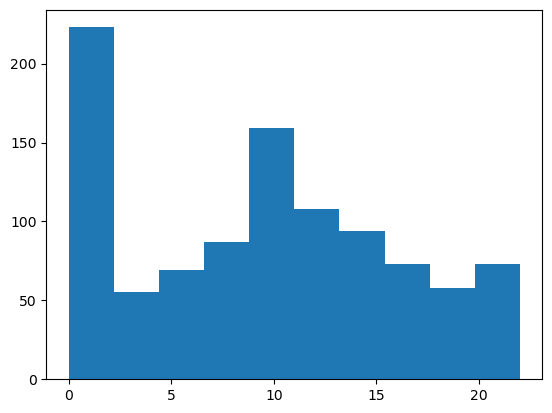

In [292]:
import matplotlib.pyplot as plt 
# Function to calculate the average non-zero deviations for each dictionary
def average_non_zero_deviations(data_samples):
    averages = []

    for dict_item in data_samples:
        total = 0
        count = 0
        for key, value in dict_item.items():
            deviation = value[0]
            if deviation != 0:
                total += deviation
                count += 1
        average = total / count if count != 0 else 0
        averages.append(average)

    return averages

# Calculate the averages
average_deviations = average_non_zero_deviations(data_samples)
average_deviations.count(0)
print(len(average_deviations))
plt.hist(average_deviations)